In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet , ElasticNetCV
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.svm import SVR
import plotly.graph_objs as go
import plotly.offline as py

In [2]:
df = pd.read_csv("SCMS_Delivery_History_Dataset_20150929.csv", sep = ',' , encoding='latin-1')

In [3]:
df.head()

,ID,Project Code,PQ #,PO / SO #,ASN/DN #,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,...,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Manufacturing Site,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD)
0,1,100-CI-T01,Pre-PQ Process,SCMS-4,ASN-8,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,...,30,19,551.00,29.00,0.97,Ranbaxy Fine Chemicals LTD,Yes,13,780.34,NaN
1,3,108-VN-T01,Pre-PQ Process,SCMS-13,ASN-85,Vietnam,PMO - US,Direct Drop,EXW,Air,...,240,1000,6200.00,6.20,0.03,"Aurobindo Unit III, India",Yes,358,4521.5,NaN
2,4,100-CI-T01,Pre-PQ Process,SCMS-20,ASN-14,Côte d'Ivoire,PMO - US,Direct Drop,FCA,Air,...,100,500,40000.00,80.00,0.80,ABBVIE GmbH & Co.KG Wiesbaden,Yes,171,1653.78,NaN
3,15,108-VN-T01,Pre-PQ Process,SCMS-78,ASN-50,Vietnam,PMO - US,Direct Drop,EXW,Air,...,60,31920,127360.80,3.99,0.07,"Ranbaxy, Paonta Shahib, India",Yes,1855,16007.06,NaN
4,16,108-VN-T01,Pre-PQ Process,SCMS-81,ASN-55,Vietnam,PMO - US,Direct Drop,EXW,Air,...,60,38000,121600.00,3.20,0.05,"Aurobindo Unit III, India",Yes,7590,45450.08,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10324 entries, 0 to 10323
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            10324 non-null  int64  
 1   Project Code                  10324 non-null  object 
 2   PQ #                          10324 non-null  object 
 3   PO / SO #                     10324 non-null  object 
 4   ASN/DN #                      10324 non-null  object 
 5   Country                       10324 non-null  object 
 6   Managed By                    10324 non-null  object 
 7   Fulfill Via                   10324 non-null  object 
 8   Vendor INCO Term              10324 non-null  object 
 9   Shipment Mode                 9964 non-null   object 
 10  PQ First Sent to Client Date  10324 non-null  object 
 11  PO Sent to Vendor Date        10324 non-null  object 
 12  Scheduled Delivery Date       10324 non-null  object 
 13  D

The columns - Scheduled Delivery Date ,Delivered to Client Date,Delivery Recorded Date ,PQ First Sent to Client Date,PO Sent to Vendor Date are dates,but are identified as 'object' type


Also, columns like Weight (Kilograms) , Freight Cost (USD) are actually numeric values , but are classified as 'object' type


We need to change the data types of above identified columns

In [5]:
df.describe()

,ID,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Line Item Insurance (USD)
count,10324.00,10324.00,10324.00,10324.00,10324.00,10324.00,10037.00
mean,51098.97,77.99,18332.53,157650.57,21.91,0.61,240.12
std,31944.33,76.58,40035.30,345292.07,45.61,3.28,500.19
min,1.00,1.00,1.00,0.00,0.00,0.00,0.00
25%,12795.75,30.00,408.00,4314.59,4.12,0.08,6.51
50%,57540.50,60.00,3000.00,30471.47,9.30,0.16,47.04
75%,83648.25,90.00,17039.75,166447.14,23.59,0.47,252.40
max,86823.00,1000.00,619999.00,5951990.40,1345.64,238.65,7708.44


<Axes: >

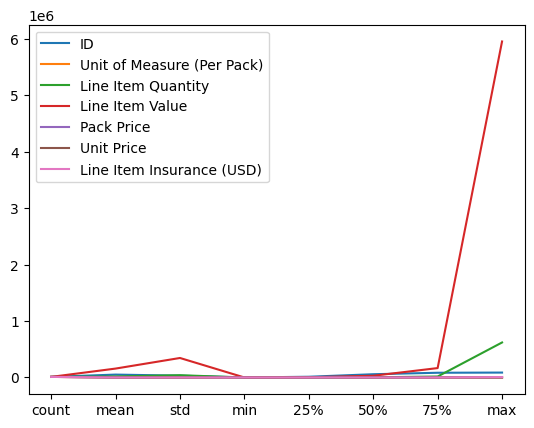

In [6]:
df.describe().plot.line()

In [7]:
df.shape #checking the shape of data

(10324, 33)

In [8]:
def check_missing(data):
    tot = data.isnull().sum().sort_values(ascending=False)
    perc = ( round(100*data.isnull().sum()/data.isnull().count(),1) ).sort_values(ascending=False)
    missing_data = pd.concat([tot, perc], axis=1, keys=['Missing', 'Percent'])
    return missing_data[:3]
    
check_missing(df)

,Missing,Percent
Dosage,1736,16.80
Shipment Mode,360,3.50
Line Item Insurance (USD),287,2.80


These three columns have some missing values, lets check whether they aer useless and can be removed or can be processed in form of other values

In [9]:
df[df['Line Item Insurance (USD)'].isna()] #looking at the values of this field and also from the data dictionary it is clear that Pre 6/1/2009 lines are still under analysis for correct rates

,ID,Project Code,PQ #,PO / SO #,ASN/DN #,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,...,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Manufacturing Site,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD)
0,1,100-CI-T01,Pre-PQ Process,SCMS-4,ASN-8,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,...,30,19,551.00,29.00,0.97,Ranbaxy Fine Chemicals LTD,Yes,13,780.34,NaN
1,3,108-VN-T01,Pre-PQ Process,SCMS-13,ASN-85,Vietnam,PMO - US,Direct Drop,EXW,Air,...,240,1000,6200.00,6.20,0.03,"Aurobindo Unit III, India",Yes,358,4521.5,NaN
2,4,100-CI-T01,Pre-PQ Process,SCMS-20,ASN-14,Côte d'Ivoire,PMO - US,Direct Drop,FCA,Air,...,100,500,40000.00,80.00,0.80,ABBVIE GmbH & Co.KG Wiesbaden,Yes,171,1653.78,NaN
3,15,108-VN-T01,Pre-PQ Process,SCMS-78,ASN-50,Vietnam,PMO - US,Direct Drop,EXW,Air,...,60,31920,127360.80,3.99,0.07,"Ranbaxy, Paonta Shahib, India",Yes,1855,16007.06,NaN
4,16,108-VN-T01,Pre-PQ Process,SCMS-81,ASN-55,Vietnam,PMO - US,Direct Drop,EXW,Air,...,60,38000,121600.00,3.20,0.05,"Aurobindo Unit III, India",Yes,7590,45450.08,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,12654,109-TZ-T01,Pre-PQ Process,SO-306,DN-144,Tanzania,PMO - US,From RDC,RDC,Air,...,25,1539,30780.00,20.00,0.80,"Standard Diagnostics, Korea",No,See DN-144 (ID#:12058),See DN-144 (ID#:12058),NaN
2496,12656,104-CI-T01,Pre-PQ Process,SO-517,DN-160,Côte d'Ivoire,PMO - US,From RDC,N/A - From RDC,NaN,...,270,460,37453.20,81.42,0.30,Roche Madrid,No,See DN-160 (ID#:11397),See DN-160 (ID#:11397),NaN
2498,12659,104-CI-T01,Pre-PQ Process,SO-518,DN-149,Côte d'Ivoire,PMO - US,From RDC,N/A - From RDC,NaN,...,40,160,12160.00,76.00,1.90,Bio-Rad Laboratories,Yes,173,1754,NaN
2499,12661,104-CI-T01,Pre-PQ Process,SO-640,DN-173,Côte d'Ivoire,PMO - US,From RDC,N/A - From RDC,NaN,...,60,35074,374590.32,10.68,0.18,"Aurobindo Unit III, India",Yes,3116,1478,NaN


In [10]:
print(df['Line Item Insurance (USD)'].mean())
print(df['Line Item Insurance (USD)'].mode())

240.11762578459698
0   0.00
Name: Line Item Insurance (USD), dtype: float64


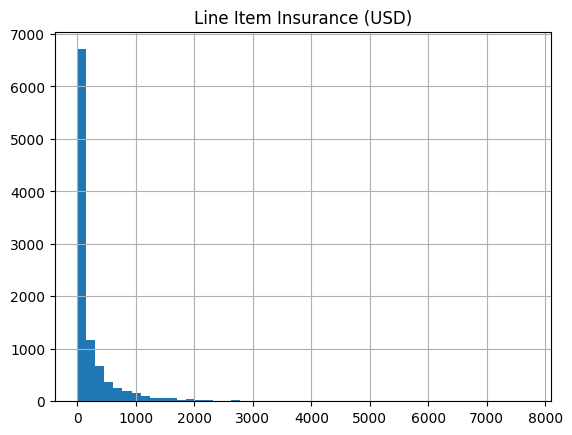

In [11]:
df.hist(column = 'Line Item Insurance (USD)' , bins = 50)
plt.show()

The mean value is quite higher and the most frequent value is 0.0 so we have two options:
1. Drop the rows
2. fill values as 0.0 (which I think will be useless)

(let's fill the values with 0.1)

In [12]:
df['Line Item Insurance (USD)'].fillna(0.1 , inplace = True)
df['Line Item Insurance (USD)'].isnull().sum()

0

In [13]:
for i in df.columns:
  print(i," : ", "\n")
  print(df[i].value_counts().head(10),"\n\n")

ID  :  

1        1
82565    1
82594    1
82595    1
82596    1
82597    1
82599    1
82600    1
82601    1
82602    1
Name: ID, dtype: int64 


Project Code  :  

116-ZA-T30    768
104-CI-T30    729
151-NG-T30    628
114-UG-T30    596
108-VN-T30    522
106-HT-T30    450
111-MZ-T30    431
110-ZM-T30    406
109-TZ-T30    369
107-RW-T30    340
Name: Project Code, dtype: int64 


PQ #  :  

Pre-PQ Process    2681
FPQ-14942          205
FPQ-12522          154
FPQ-13973          110
FPQ-4537            98
FPQ-8840            90
FPQ-5303            78
FPQ-7175            78
FPQ-6262            75
FPQ-5023            70
Name: PQ #, dtype: int64 


PO / SO #  :  

SCMS-199289    67
SCMS-199283    63
SCMS-183950    55
SCMS-215370    38
SCMS-259075    38
SCMS-259079    33
SCMS-215410    26
SCMS-23500     26
SCMS-259078    20
SCMS-162440    20
Name: PO / SO #, dtype: int64 


ASN/DN #  :  

ASN-19166    54
ASN-24415    38
ASN-23875    26
ASN-32138    19
ASN-28034    17
ASN-30792    17
ASN-28036  

The Above step  gives lot of information:

1. The first 5 columns are just ID's and they can be used for analysis stuff but can be removed in the model building process or in the processed dataset
2. Apart from NaN's this data has missing data in various other forms as well, for eg. in weights column "Weight Captured Separately    1507"; The Dates columns has many values saying "Date Not Captured",etc. This needs to be looked upon
3. There are 2 categories for same values in "PO Sent to Vendor Date" and "Vendor INCO Term" called RDC and NA-By RDC
4. Almost every shipment is managed by PMO-US, so the managed by column is also safe to delete
5. Delivery Recorded Date is almost same as Delivered to client date and as per data dictionary we know that it is the date at which documents are recieved, so it does not contribute to shipping cost. So it's also safe to delete
6. Item Description has been broken down in subcategories in next few columns like molecule, dosage, dosage type

In [14]:
#For Shipment weight
df['Weight_new']=0
for i in range(df.shape[0]):

    if df['Weight (Kilograms)'].loc[i]  in ["Weight Captured Separately"]:
        df['Weight_new'].loc[i]=df['Weight (Kilograms)'].loc[i]

    elif df['Weight (Kilograms)'].loc[i].split(" ")[0]=="See":
        df['Weight_new'].loc[i]="See ASN/DN Tag"

    else :
        df['Weight_new'].loc[i]="Normal Measurement"

In [15]:
#for freight cost
df['Freight_cost_new']=0
for i in range(df.shape[0]):

    if df['Freight Cost (USD)'].loc[i]  in ["Freight Included in Commodity Cost",'Invoiced Separately']:
        df['Freight_cost_new'].loc[i]=df['Freight Cost (USD)'].loc[i]

    elif df['Freight Cost (USD)'].loc[i].split(" ")[0]=="See":
        df['Freight_cost_new'].loc[i]="See ASN/DN Tag"

    else :
        df['Freight_cost_new'].loc[i]="Normal Measurement"


In [16]:
df['Weight_new'].value_counts()

Normal Measurement            6372
See ASN/DN Tag                2445
Weight Captured Separately    1507
Name: Weight_new, dtype: int64

In [17]:
df['Freight_cost_new'].value_counts()


Normal Measurement                    6198
See ASN/DN Tag                        2445
Freight Included in Commodity Cost    1442
Invoiced Separately                    239
Name: Freight_cost_new, dtype: int64

In [18]:
#Converting to datetime format
for i in ['Scheduled Delivery Date', 'Delivered to Client Date']:
    df[i]=pd.to_datetime(df[i], infer_datetime_format=True) 

#Converting to Numeric
for i in ['Weight (Kilograms)', 'Freight Cost (USD)']:
    df[i]=pd.to_numeric(df[i] , errors="coerce")

####Lets also delete the 1st 5 columns as well as some other columns like PO sent and PQ First Sent columns because they contain many unknown values, and honestly speaking I dont think they would be useful

In [19]:
cl_df = df.drop(columns =['ID', 'Project Code', 'PQ #', 'PO / SO #', 'ASN/DN #', "PQ First Sent to Client Date","PO Sent to Vendor Date", 'Delivery Recorded Date' , 'Managed By', 'Item Description'] , axis = 1)

In [20]:
cl_df.head(10)

,Country,Fulfill Via,Vendor INCO Term,Shipment Mode,Scheduled Delivery Date,Delivered to Client Date,Product Group,Sub Classification,Vendor,Molecule/Test Type,...,Line Item Value,Pack Price,Unit Price,Manufacturing Site,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD),Weight_new,Freight_cost_new
0,Côte d'Ivoire,Direct Drop,EXW,Air,2006-06-02,2006-06-02,HRDT,HIV test,RANBAXY Fine Chemicals LTD.,"HIV, Reveal G3 Rapid HIV-1 Antibody Test",...,551.00,29.00,0.97,Ranbaxy Fine Chemicals LTD,Yes,13.00,780.34,0.10,Normal Measurement,Normal Measurement
1,Vietnam,Direct Drop,EXW,Air,2006-11-14,2006-11-14,ARV,Pediatric,Aurobindo Pharma Limited,Nevirapine,...,6200.00,6.20,0.03,"Aurobindo Unit III, India",Yes,358.00,4521.50,0.10,Normal Measurement,Normal Measurement
2,Côte d'Ivoire,Direct Drop,FCA,Air,2006-08-27,2006-08-27,HRDT,HIV test,Abbott GmbH & Co. KG,"HIV 1/2, Determine Complete HIV Kit",...,40000.00,80.00,0.80,ABBVIE GmbH & Co.KG Wiesbaden,Yes,171.00,1653.78,0.10,Normal Measurement,Normal Measurement
3,Vietnam,Direct Drop,EXW,Air,2006-09-01,2006-09-01,ARV,Adult,SUN PHARMACEUTICAL INDUSTRIES LTD (RANBAXY LAB...,Lamivudine,...,127360.80,3.99,0.07,"Ranbaxy, Paonta Shahib, India",Yes,1855.00,16007.06,0.10,Normal Measurement,Normal Measurement
4,Vietnam,Direct Drop,EXW,Air,2006-08-11,2006-08-11,ARV,Adult,Aurobindo Pharma Limited,Stavudine,...,121600.00,3.20,0.05,"Aurobindo Unit III, India",Yes,7590.00,45450.08,0.10,Normal Measurement,Normal Measurement
5,Nigeria,Direct Drop,EXW,Air,2006-09-28,2006-09-28,ARV,Pediatric,Aurobindo Pharma Limited,Zidovudine,...,2225.60,5.35,0.02,"Aurobindo Unit III, India",Yes,504.00,5920.42,0.10,Normal Measurement,Normal Measurement
6,Zambia,Direct Drop,DDU,Air,2007-01-08,2007-01-08,ARV,Pediatric,MERCK SHARP & DOHME IDEA GMBH (FORMALLY MERCK ...,Efavirenz,...,4374.00,32.40,0.36,MSD South Granville Australia,Yes,328.00,NaN,0.10,Normal Measurement,Freight Included in Commodity Cost
7,Tanzania,Direct Drop,EXW,Air,2006-11-24,2006-11-24,ARV,Adult,Aurobindo Pharma Limited,Nevirapine,...,60834.55,3.65,0.06,"Aurobindo Unit III, India",Yes,1478.00,6212.41,0.10,Normal Measurement,Normal Measurement
8,Nigeria,Direct Drop,EXW,Air,2006-12-07,2006-12-07,ARV,Adult,Aurobindo Pharma Limited,Stavudine,...,532.35,1.95,0.03,"Aurobindo Unit III, India",No,NaN,NaN,0.10,See ASN/DN Tag,See ASN/DN Tag
9,Zambia,Direct Drop,CIP,Air,2007-01-30,2007-01-30,ARV,Adult,ABBVIE LOGISTICS (FORMERLY ABBOTT LOGISTICS BV),Lopinavir/Ritonavir,...,115080.00,41.10,0.34,ABBVIE (Abbott) St. P'burg USA,Yes,643.00,NaN,0.10,Normal Measurement,Freight Included in Commodity Cost


In [21]:
#replacing N/A from RDC as RDC
cl_df.replace('N/A - From RDC', 'RDC', inplace=True)

In [22]:
cl_df.isnull().sum()

Country                          0
Fulfill Via                      0
Vendor INCO Term                 0
Shipment Mode                  360
Scheduled Delivery Date          0
Delivered to Client Date         0
Product Group                    0
Sub Classification               0
Vendor                           0
Molecule/Test Type               0
Brand                            0
Dosage                        1736
Dosage Form                      0
Unit of Measure (Per Pack)       0
Line Item Quantity               0
Line Item Value                  0
Pack Price                       0
Unit Price                       0
Manufacturing Site               0
First Line Designation           0
Weight (Kilograms)            3952
Freight Cost (USD)            4126
Line Item Insurance (USD)        0
Weight_new                       0
Freight_cost_new                 0
dtype: int64

In [23]:
# Random Sample Imputation for Categorical Columns
for col in ['Dosage', 'Shipment Mode']:
    rand_samples=cl_df[col].dropna().sample(cl_df[col].isnull().sum())
    rand_samples.index=cl_df[cl_df[col].isnull()].index
    cl_df.loc[cl_df[col].isnull(),col]=rand_samples

In [24]:
# KNN Imputation for numerical columns
from sklearn.impute import KNNImputer

for col in ['Weight (Kilograms)', 'Freight Cost (USD)'] :
        imputer=KNNImputer(n_neighbors=10)
        cl_df[col]=imputer.fit_transform(cl_df[[col]])

In [25]:
cl_df.isnull().sum()

Country                       0
Fulfill Via                   0
Vendor INCO Term              0
Shipment Mode                 0
Scheduled Delivery Date       0
Delivered to Client Date      0
Product Group                 0
Sub Classification            0
Vendor                        0
Molecule/Test Type            0
Brand                         0
Dosage                        0
Dosage Form                   0
Unit of Measure (Per Pack)    0
Line Item Quantity            0
Line Item Value               0
Pack Price                    0
Unit Price                    0
Manufacturing Site            0
First Line Designation        0
Weight (Kilograms)            0
Freight Cost (USD)            0
Line Item Insurance (USD)     0
Weight_new                    0
Freight_cost_new              0
dtype: int64

## Analysis of Data

In [26]:
# getting index of object type colums
categ_index=df.dtypes[df.dtypes=='object'].index

# getting index of numeric type columns
floats=df.dtypes[df.dtypes=='float64'].index
ints=df.dtypes[df.dtypes=='int64'].index

num_index=floats.append(ints)

# getting index of datetime columns
date_index=df.dtypes[df.dtypes=='datetime64[ns]'].index

Text(0, 0.5, 'Shipment Value')

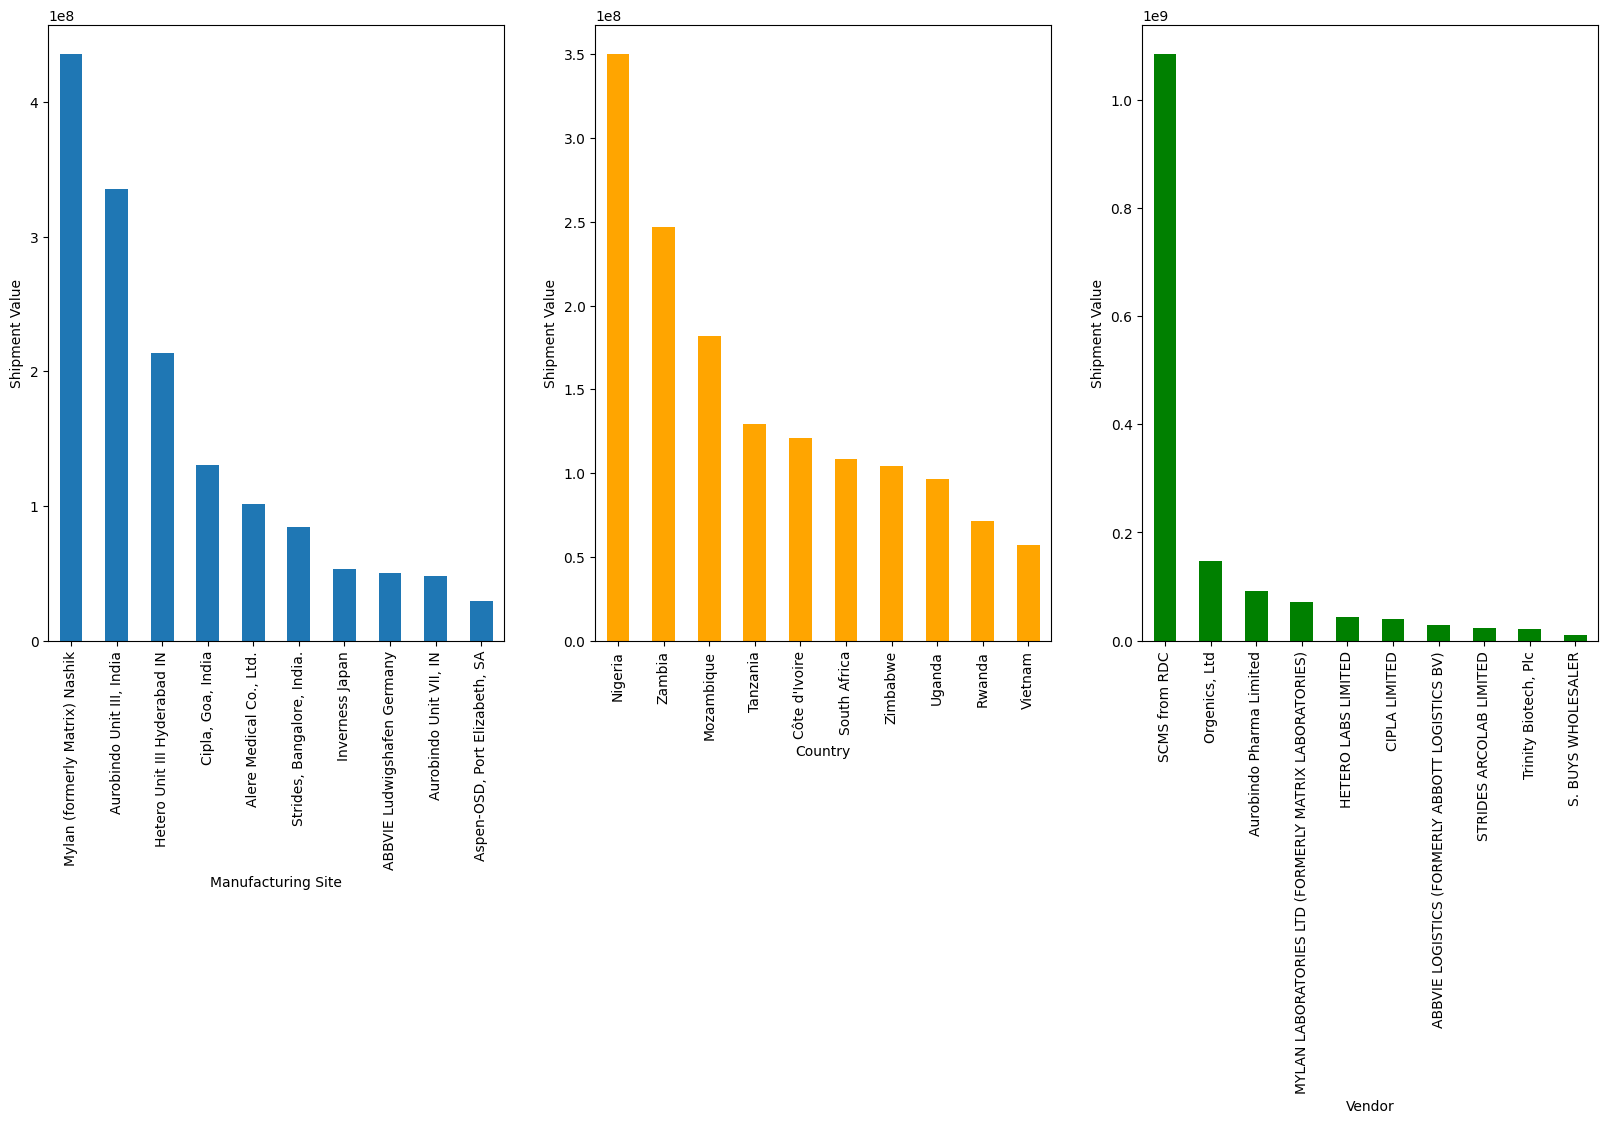

In [27]:
fig,ax=plt.subplots(1,3,figsize=(20,8))

#Top 10 Manufacturing sites by Total Price/Value of Packs produced 
df.groupby(['Manufacturing Site'])['Line Item Value'].sum().nlargest(10).plot(kind='bar',ax=ax[0])
ax[0].set_ylabel('Shipment Value')

#Top 10 Countries by Total Price/Value of Packs produced 
df.groupby(['Country'])['Line Item Value'].sum().nlargest(10).plot(kind='bar',ax=ax[1] , color = 'orange')
ax[1].set_ylabel('Shipment Value')

#Top 10 Vendors sites by Total Price/Value of Packs produced 
df.groupby(['Vendor'])['Line Item Value'].sum().nlargest(10).plot(kind='bar',ax=ax[2] , color = 'green')
ax[2].set_ylabel('Shipment Value')

Text(0, 0.5, 'Shipment Value')

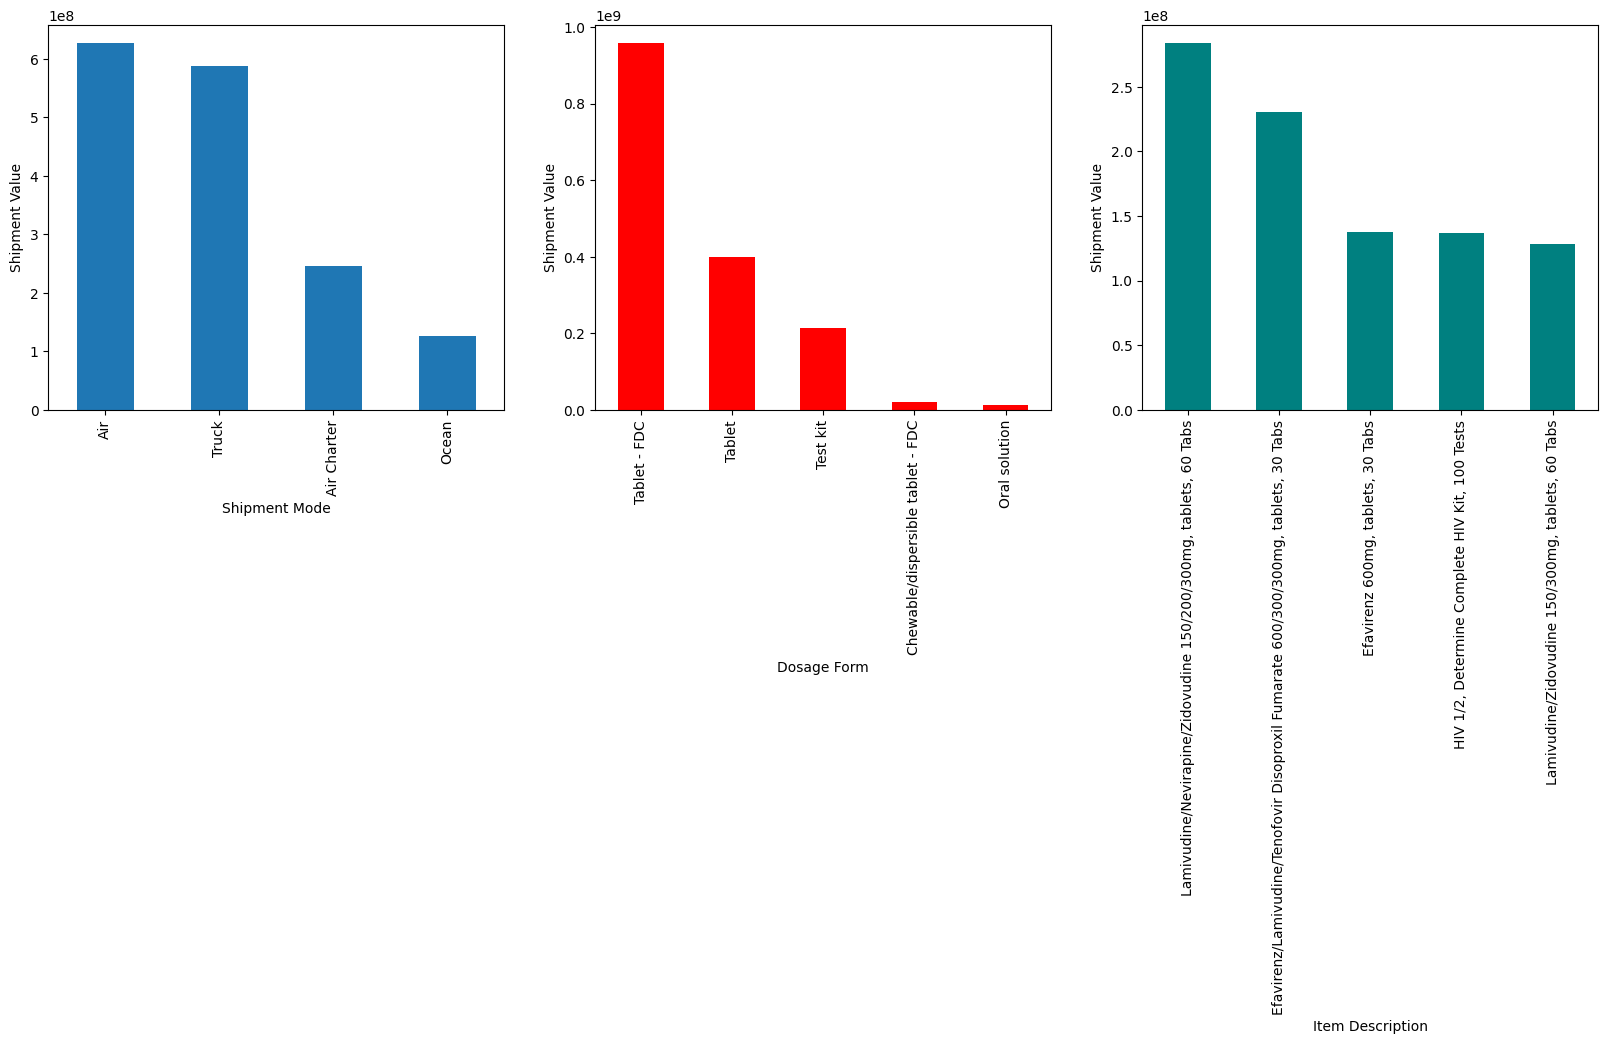

In [28]:
fig,ax=plt.subplots(1,3,figsize=(20,5))

#Top Shipment modes by Total Price/Value of Packs produced 
df.groupby(['Shipment Mode'])['Line Item Value'].sum().nlargest(5).plot(kind='bar',ax=ax[0])
ax[0].set_ylabel('Shipment Value')

#Top Dosage Forms by Total Price/Value of Packs produced 
df.groupby(['Dosage Form'])['Line Item Value'].sum().nlargest(5).plot(kind='bar',ax=ax[1], color = 'red')
ax[1].set_ylabel('Shipment Value')

#Top Items by Total Price/Value of Packs produced 
df.groupby(['Item Description'])['Line Item Value'].sum().nlargest(5).plot(kind='bar',ax=ax[2] , color = 'teal')
plt.xticks(rotation=90)
ax[2].set_ylabel('Shipment Value')

Text(0, 0.5, 'Shipment Value')

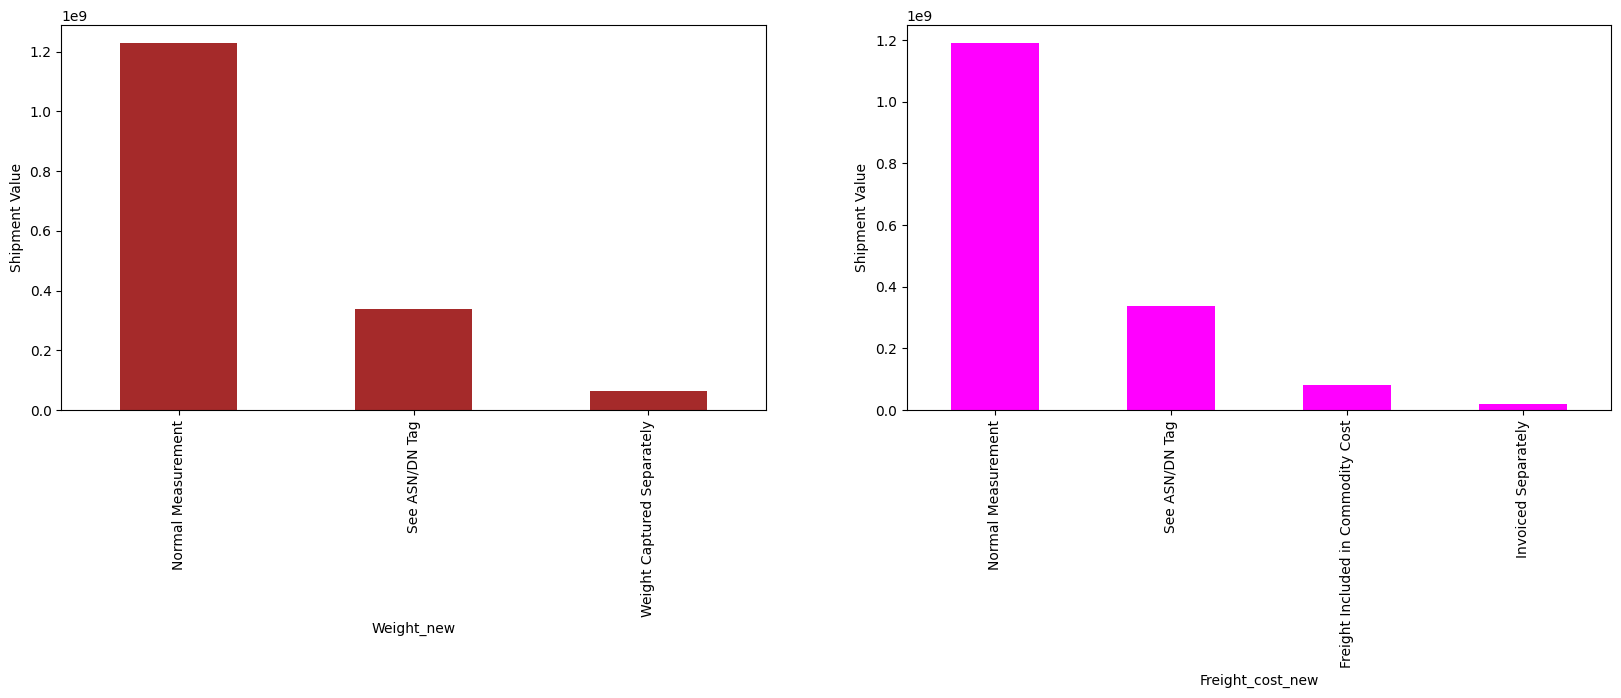

In [29]:
fig,ax=plt.subplots(1,2,figsize=(20,5))

#Top Weight categories by Total Price/Value of Packs produced
df.groupby(['Weight_new'])['Line Item Value'].sum().nlargest(5).plot(kind='bar',ax=ax[0] , color = 'brown')
ax[0].set_ylabel('Shipment Value')

#Top Freight cost categories by Total Price/Value of Packs produced 
df.groupby(['Freight_cost_new'])['Line Item Value'].sum().nlargest(5).plot(kind='bar',ax=ax[1], color = 'magenta')
ax[1].set_ylabel('Shipment Value')

<Axes: >

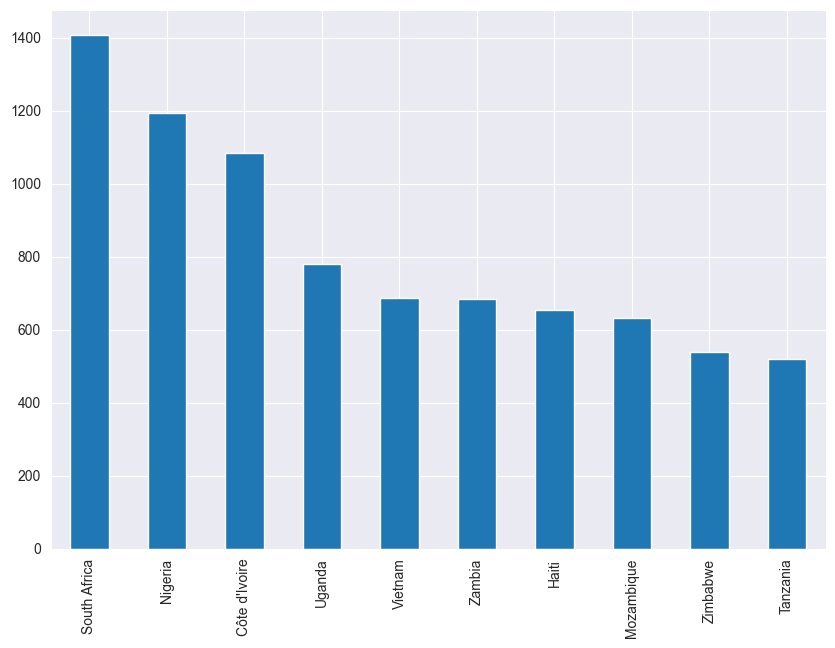

In [30]:
#Count of shipments according to coutries (You can also view this in value counts)
sns.set_style('darkgrid')
country = df['Country'].value_counts().head(10)
fig, ax = plt.subplots(figsize=(10,7))
country.plot.bar(ax=ax)

In [31]:
#Let's see how many times the expected delivery date and actual delivery date matches
cl_df['Schedule v Actual'] = cl_df['Scheduled Delivery Date'] - cl_df['Delivered to Client Date']
cl_df['Schedule v Actual'].value_counts().head(20)

0 days      4832
17 days      118
6 days       105
8 days        97
-59 days      95
13 days       87
-89 days      84
-30 days      82
19 days       76
10 days       74
2 days        72
31 days       72
1 days        70
11 days       69
7 days        68
207 days      67
14 days       67
59 days       64
29 days       61
3 days        59
Name: Schedule v Actual, dtype: int64

So around 50% of the times the expected date matches the actual date

In [32]:
cl_df['Schedule v Actual'] = cl_df['Schedule v Actual'] / pd.Timedelta(days=1)
cl_df['Schedule v Actual']

0        0.00
1        0.00
2        0.00
3        0.00
4        0.00
         ... 
10319   16.00
10320   -6.00
10321    6.00
10322   36.00
10323   27.00
Name: Schedule v Actual, Length: 10324, dtype: float64

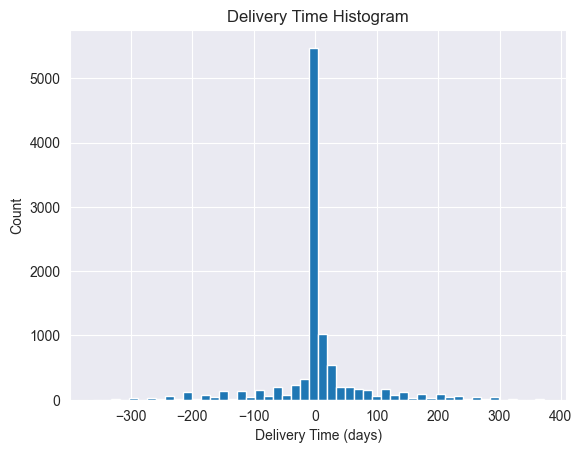

In [33]:
cl_df['Schedule v Actual'].plot.hist(bins=50)
plt.title('Delivery Time Histogram')
plt.xlabel('Delivery Time (days)')
plt.ylabel('Count')
plt.show()

<Axes: title={'center': 'Freight Cost (USD) over Time'}, xlabel='Delivered to Client Date'>

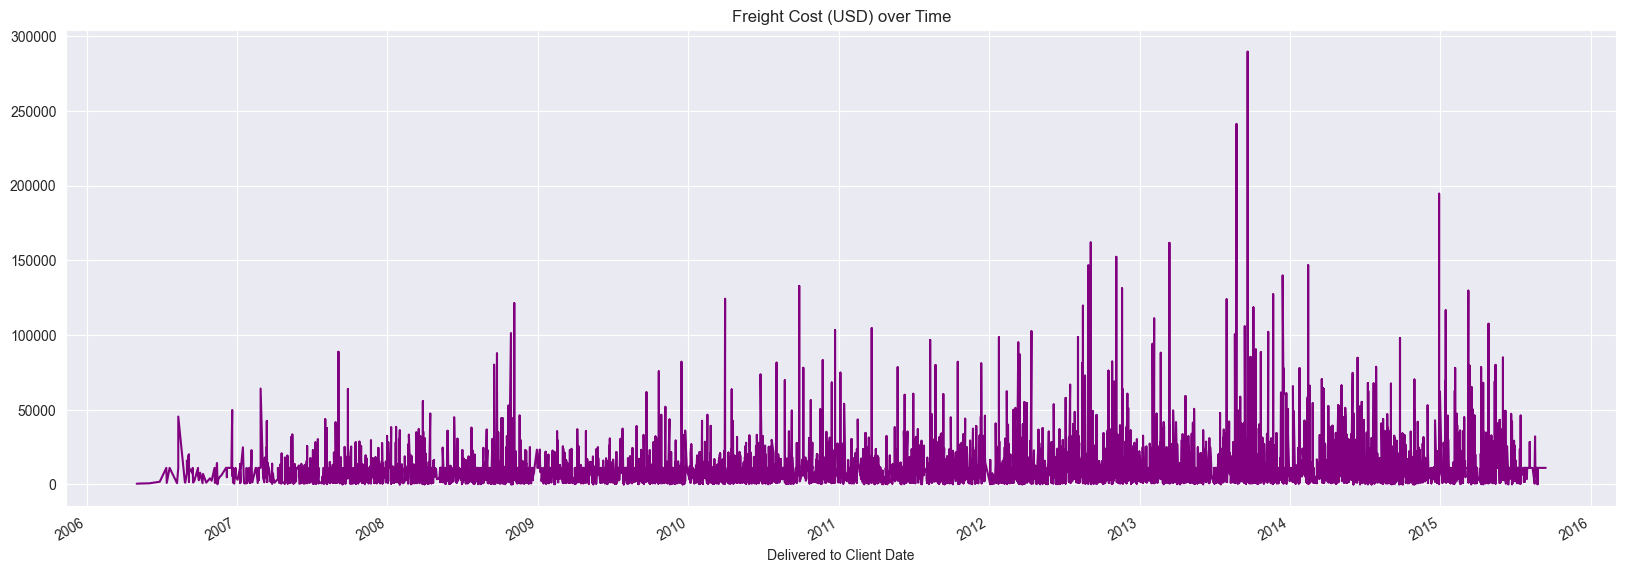

In [34]:
dt = cl_df.set_index('Delivered to Client Date')['Freight Cost (USD)']
fig, ax = plt.subplots(figsize=(20,7))
dt.plot(title='Freight Cost (USD) over Time' , color = 'purple' , kind = 'line')

In [35]:
ShippingMode = cl_df["Shipment Mode"].value_counts()
labels = (np.array(ShippingMode.index))
sizes = (np.array((ShippingMode / ShippingMode.sum())*100))

trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(title="Shipment Mode")
dat = [trace]
fig = go.Figure(data=dat, layout=layout)
py.iplot(fig, filename="Shipment Mode")

Manufacturing Site
Aurobindo Unit III, India         3172
Mylan (formerly Matrix) Nashik    1415
Hetero Unit III Hyderabad IN       869
Cipla, Goa, India                  665
Strides, Bangalore, India.         540
Alere Medical Co., Ltd.            481
Trinity Biotech, Plc               405
ABBVIE Ludwigshafen Germany        366
Inverness Japan                    345
ABBVIE (Abbott) Logis. UK          219
dtype: int64 



Text(0.5, 0, 'Manufacturing Site Name')

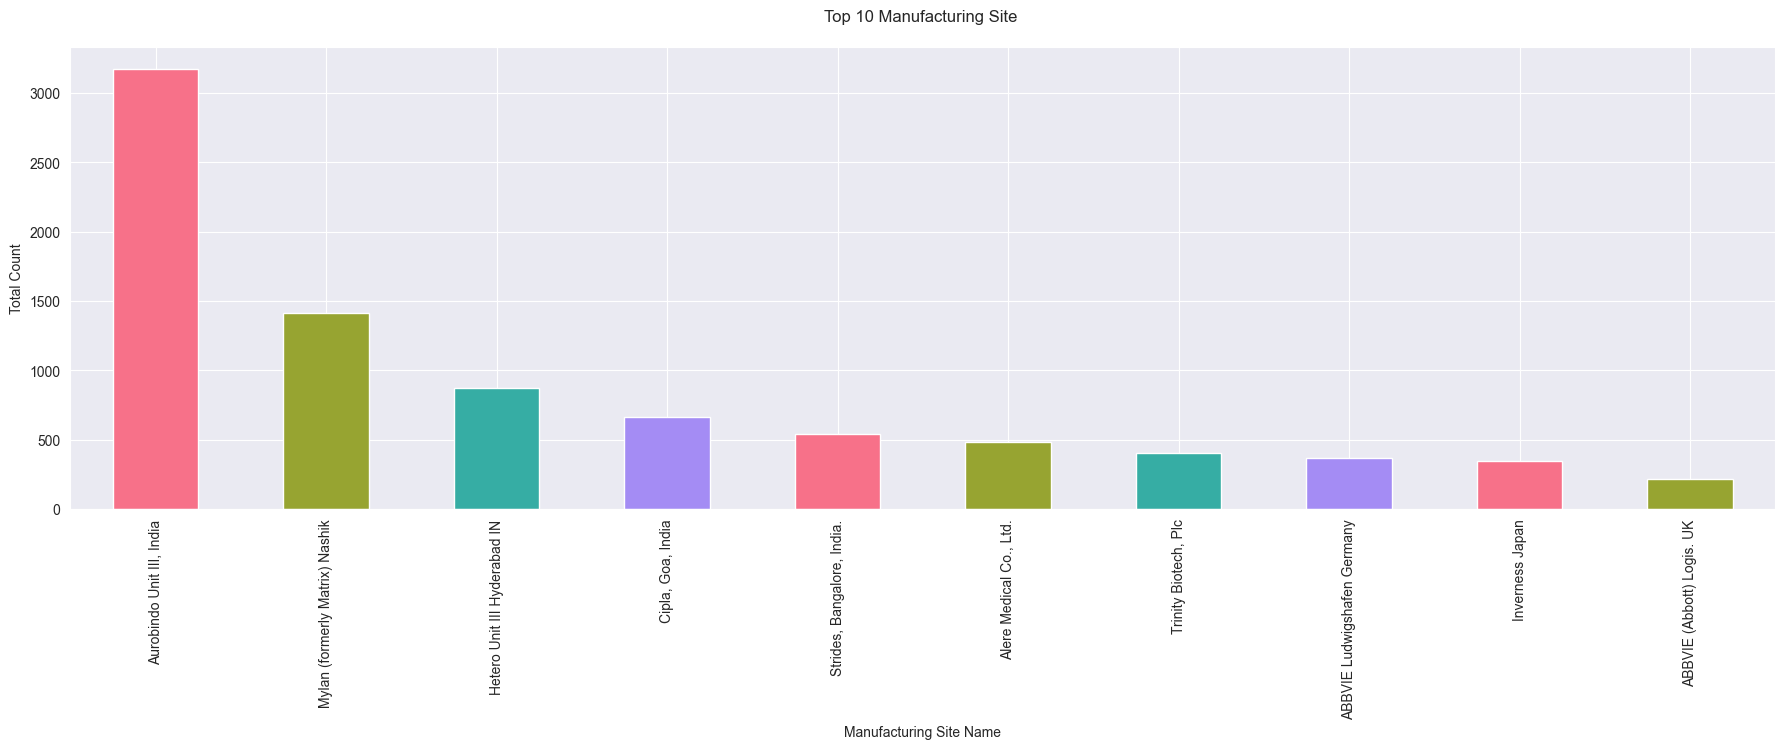

In [36]:
plt.figure(figsize=(22,6))
palette = sns.color_palette("husl", 4)
TopFiveManufacturingSite=cl_df.groupby('Manufacturing Site').size().nlargest(10)
print(TopFiveManufacturingSite , "\n")
TopFiveManufacturingSite.plot(kind='bar' , color = palette)
plt.title('Top 10 Manufacturing Site \n')
plt.ylabel('Total Count')
plt.xlabel('Manufacturing Site Name')

## One can try even more analysis steps to get for insights about various parameters, thier relations, etc from the data

<Figure size 1440x1440 with 0 Axes>

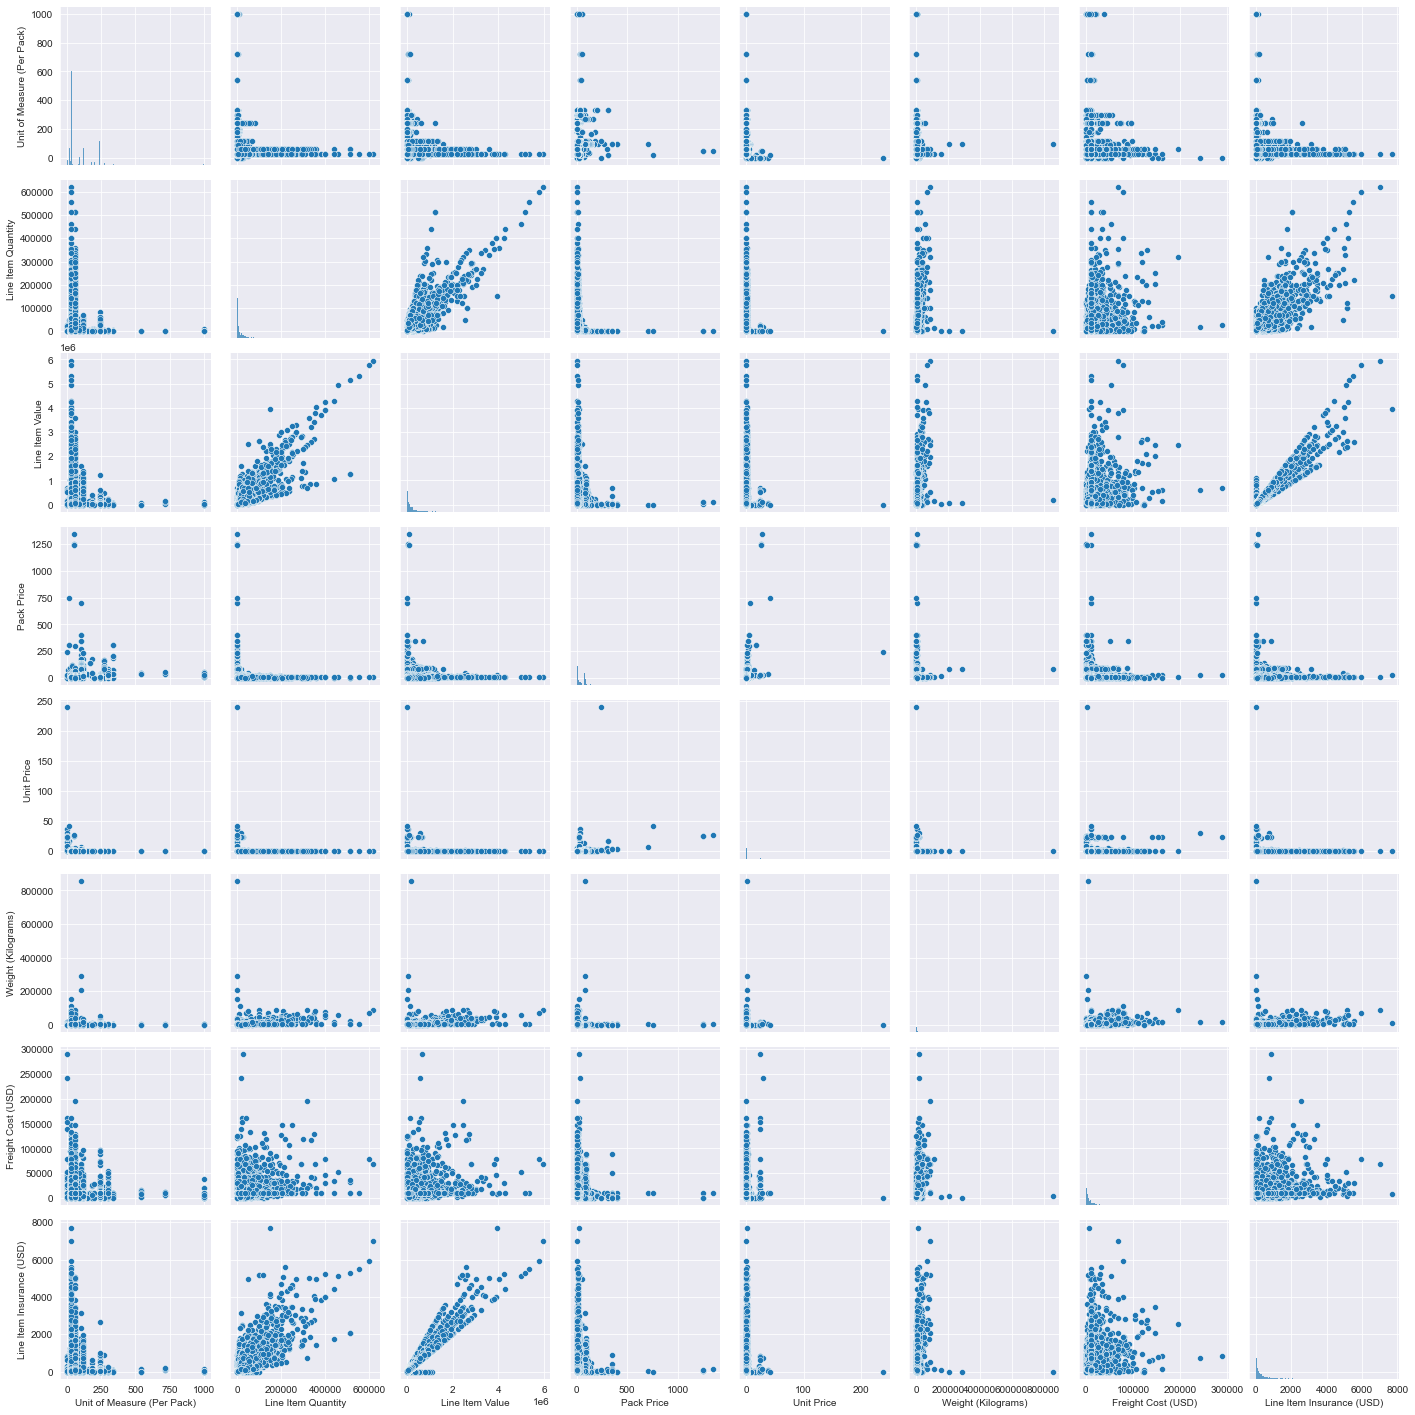

In [ ]:
plt.figure(figsize=(20,20))
sns.pairplot(cl_df)

In [37]:
num_index

Index(['Line Item Value', 'Pack Price', 'Unit Price', 'Weight (Kilograms)',
       'Freight Cost (USD)', 'Line Item Insurance (USD)', 'ID',
       'Unit of Measure (Per Pack)', 'Line Item Quantity'],
      dtype='object')

In [38]:
num = list(num_index)
num.remove('ID')

array([[<Axes: title={'center': 'Line Item Value'}>,
        <Axes: title={'center': 'Pack Price'}>,
        <Axes: title={'center': 'Unit Price'}>],
       [<Axes: title={'center': 'Weight (Kilograms)'}>,
        <Axes: title={'center': 'Freight Cost (USD)'}>,
        <Axes: title={'center': 'Line Item Insurance (USD)'}>],
       [<Axes: title={'center': 'Unit of Measure (Per Pack)'}>,
        <Axes: title={'center': 'Line Item Quantity'}>, <Axes: >]],
      dtype=object)

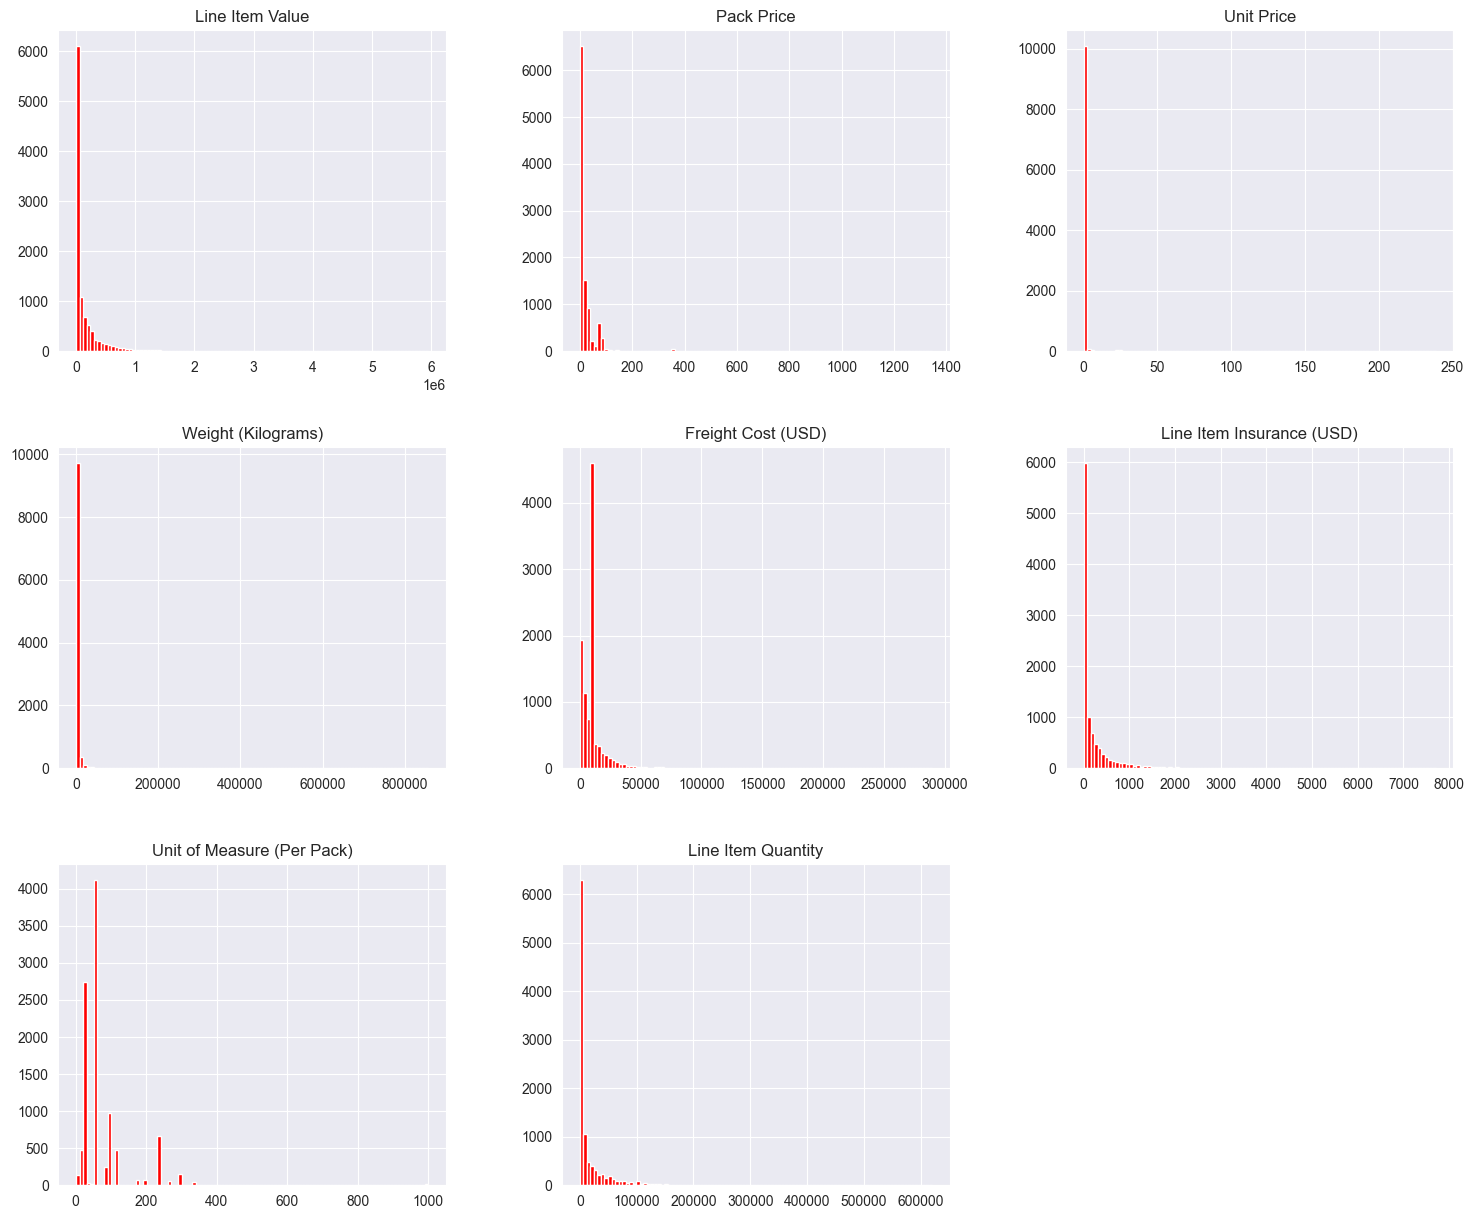

In [39]:
cl_df.hist(num,figsize=(18,15),color='red', bins = 100)

From both the pairplot and histograms we can clearly see that the data is highly skewed, need to work on this

<Axes: >

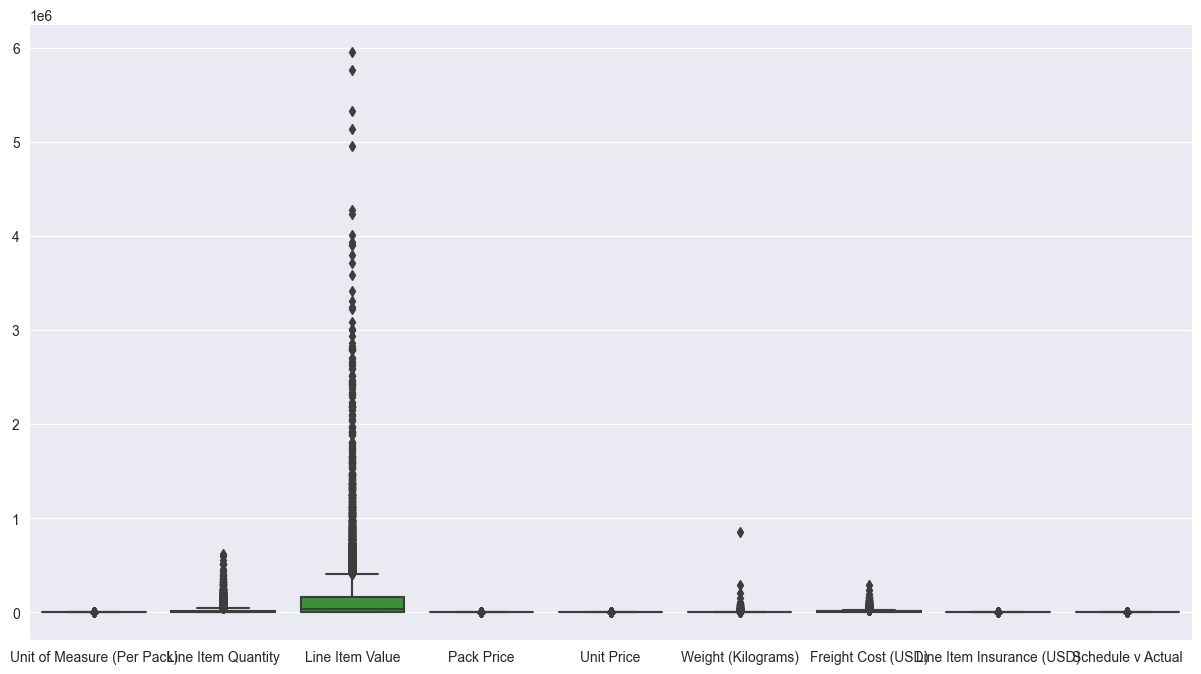

In [40]:
plt.figure(figsize = (15, 8))
sns.boxplot(data = cl_df)

In [41]:
# Apply Log + 1 transformation to normalize skewed data while accounting for zeros.
for col in num:
    cl_df[col] = np.log(cl_df[col]+2)

array([[<Axes: title={'center': 'Line Item Value'}>,
        <Axes: title={'center': 'Pack Price'}>,
        <Axes: title={'center': 'Unit Price'}>],
       [<Axes: title={'center': 'Weight (Kilograms)'}>,
        <Axes: title={'center': 'Freight Cost (USD)'}>,
        <Axes: title={'center': 'Line Item Insurance (USD)'}>],
       [<Axes: title={'center': 'Unit of Measure (Per Pack)'}>,
        <Axes: title={'center': 'Line Item Quantity'}>, <Axes: >]],
      dtype=object)

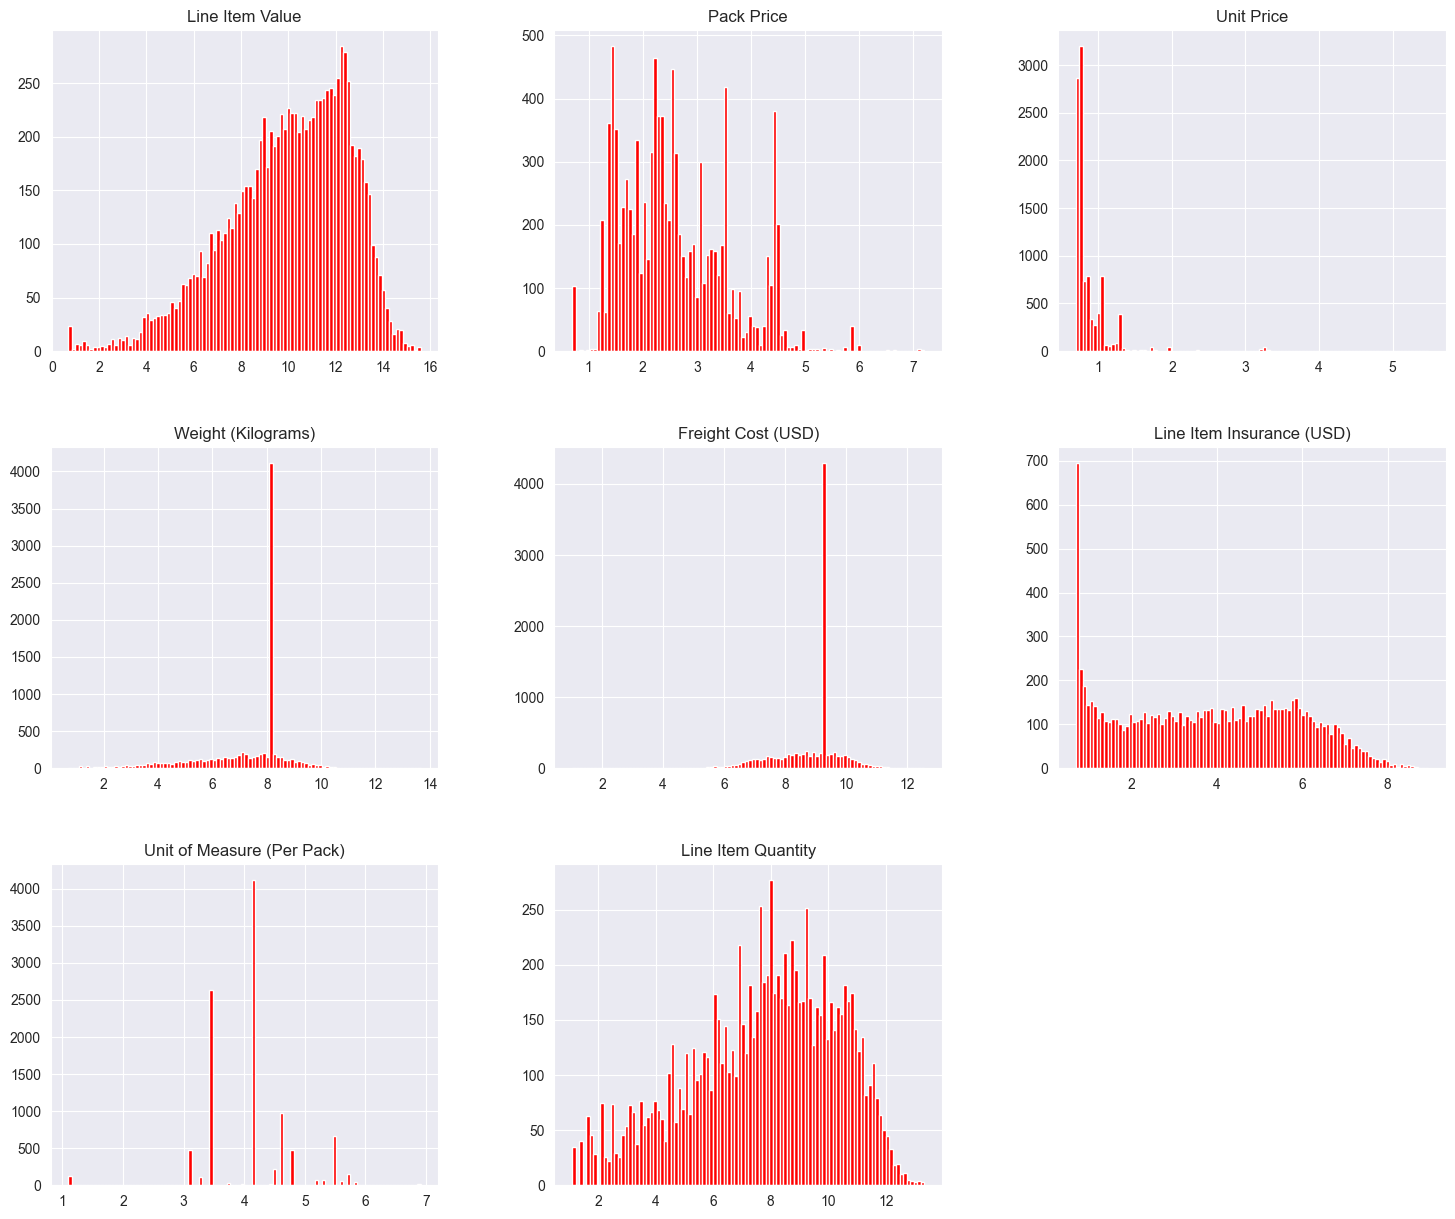

In [42]:
cl_df.hist(num,figsize=(18,15),color='red', bins = 100)

Treating Outliers

In [43]:
def outlier_thresholds_iqr(df, feature, th1, th3):
    Q1 = df[feature].quantile(th1)
    Q3 = df[feature].quantile(th3)
    IQR = Q3 - Q1
    upper_limit = Q3 + 3 * IQR
    lower_limit = Q1 - 1 * IQR
    return upper_limit, lower_limit

In [44]:
def check_outliers_iqr(df, feature):
    upper_limit, lower_limit = outlier_thresholds_iqr(df, feature, th1=0.25, th3=0.75)
    if df[(df[feature] > upper_limit) | (df[feature] < lower_limit)].any(axis=None):
        return True
    else:
        return False

In [45]:
outliers_list = []
for i in num:
  if check_outliers_iqr(cl_df, i) == True:
    print(i)
    outliers_list.append(i)
  else:
    pass
  

Line Item Value
Unit Price
Weight (Kilograms)
Freight Cost (USD)
Unit of Measure (Per Pack)
Line Item Quantity


In [46]:
outliers_list

['Line Item Value',
 'Unit Price',
 'Weight (Kilograms)',
 'Freight Cost (USD)',
 'Unit of Measure (Per Pack)',
 'Line Item Quantity']

In [47]:
# remove outliers
for i in outliers_list:
  upper_limit, lower_limit = outlier_thresholds_iqr(cl_df, i, th1=0.20, th3=0.80) #keeping 0.20 and 0.80 here because, keeping stansard values (.25 , .75) lead to lot of loss of data, keeping only 6k rows
  cl_df = cl_df[(cl_df[i] > lower_limit) & (cl_df[i] < upper_limit)]

<Axes: >

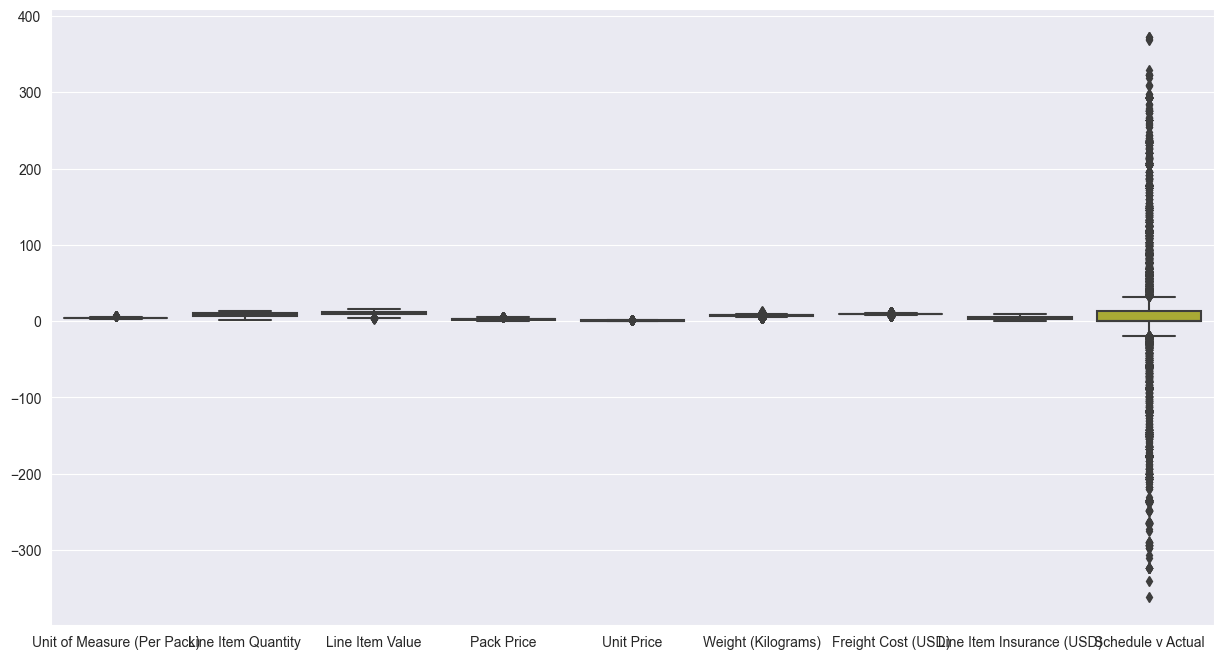

In [48]:
plt.figure(figsize = (15, 8))
sns.boxplot(data = cl_df)

In [49]:
cl_df.shape #Now we have 8.8k rows compared to initial 10K rows

(8823, 26)

#Feature Processing and Selection 

We first add a column named shipping cost denoting the final price including fright cost and product cost + insurance cost

In [50]:
cl_df['Shipping_cost'] = cl_df['Freight Cost (USD)']+cl_df['Line Item Value']+cl_df['Line Item Insurance (USD)']
cl_df["Shipping_cost"].round(decimals=2)

1       17.89
2       18.75
3       22.18
4       23.17
5       17.14
         ... 
10319   29.18
10320   26.24
10321   33.34
10322   25.87
10323   24.99
Name: Shipping_cost, Length: 8823, dtype: float64

<Axes: ylabel='Frequency'>

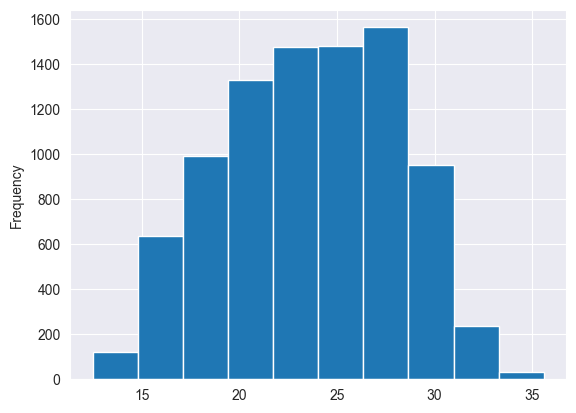

In [51]:
cl_df.Shipping_cost.plot(kind = 'hist')

Our Aim will be to predict this price, so we will check which columns contribute most to this column

In [52]:
cl_df.columns

Index(['Country', 'Fulfill Via', 'Vendor INCO Term', 'Shipment Mode',
       'Scheduled Delivery Date', 'Delivered to Client Date', 'Product Group',
       'Sub Classification', 'Vendor', 'Molecule/Test Type', 'Brand', 'Dosage',
       'Dosage Form', 'Unit of Measure (Per Pack)', 'Line Item Quantity',
       'Line Item Value', 'Pack Price', 'Unit Price', 'Manufacturing Site',
       'First Line Designation', 'Weight (Kilograms)', 'Freight Cost (USD)',
       'Line Item Insurance (USD)', 'Weight_new', 'Freight_cost_new',
       'Schedule v Actual', 'Shipping_cost'],
      dtype='object')

In [53]:
cl_df

,Country,Fulfill Via,Vendor INCO Term,Shipment Mode,Scheduled Delivery Date,Delivered to Client Date,Product Group,Sub Classification,Vendor,Molecule/Test Type,...,Unit Price,Manufacturing Site,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD),Weight_new,Freight_cost_new,Schedule v Actual,Shipping_cost
1,Vietnam,Direct Drop,EXW,Air,2006-11-14,2006-11-14,ARV,Pediatric,Aurobindo Pharma Limited,Nevirapine,...,0.71,"Aurobindo Unit III, India",Yes,5.89,8.42,0.74,Normal Measurement,Normal Measurement,0.00,17.89
2,Côte d'Ivoire,Direct Drop,FCA,Air,2006-08-27,2006-08-27,HRDT,HIV test,Abbott GmbH & Co. KG,"HIV 1/2, Determine Complete HIV Kit",...,1.03,ABBVIE GmbH & Co.KG Wiesbaden,Yes,5.15,7.41,0.74,Normal Measurement,Normal Measurement,0.00,18.75
3,Vietnam,Direct Drop,EXW,Air,2006-09-01,2006-09-01,ARV,Adult,SUN PHARMACEUTICAL INDUSTRIES LTD (RANBAXY LAB...,Lamivudine,...,0.73,"Ranbaxy, Paonta Shahib, India",Yes,7.53,9.68,0.74,Normal Measurement,Normal Measurement,0.00,22.18
4,Vietnam,Direct Drop,EXW,Air,2006-08-11,2006-08-11,ARV,Adult,Aurobindo Pharma Limited,Stavudine,...,0.72,"Aurobindo Unit III, India",Yes,8.93,10.72,0.74,Normal Measurement,Normal Measurement,0.00,23.17
5,Nigeria,Direct Drop,EXW,Air,2006-09-28,2006-09-28,ARV,Pediatric,Aurobindo Pharma Limited,Zidovudine,...,0.70,"Aurobindo Unit III, India",Yes,6.23,8.69,0.74,Normal Measurement,Normal Measurement,0.00,17.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10319,Zimbabwe,From RDC,RDC,Truck,2015-07-31,2015-07-15,ARV,Pediatric,SCMS from RDC,Lamivudine/Nevirapine/Zidovudine,...,0.72,"Mylan, H-12 & H-13, India",No,8.14,9.32,6.56,See ASN/DN Tag,See ASN/DN Tag,16.00,29.18
10320,Côte d'Ivoire,From RDC,RDC,Truck,2015-07-31,2015-08-06,ARV,Adult,SCMS from RDC,Lamivudine/Zidovudine,...,0.75,Hetero Unit III Hyderabad IN,No,8.14,9.32,5.10,See ASN/DN Tag,See ASN/DN Tag,-6.00,26.24
10321,Zambia,From RDC,RDC,Truck,2015-08-31,2015-08-25,ARV,Adult,SCMS from RDC,Efavirenz/Lamivudine/Tenofovir Disoproxil Fuma...,...,0.85,Cipla Ltd A-42 MIDC Mahar. IN,No,8.14,9.32,8.57,Weight Captured Separately,Freight Included in Commodity Cost,6.00,33.34
10322,Zimbabwe,From RDC,RDC,Truck,2015-09-09,2015-08-04,ARV,Adult,SCMS from RDC,Lamivudine/Zidovudine,...,0.75,Mylan (formerly Matrix) Nashik,Yes,7.24,9.32,4.91,Normal Measurement,Freight Included in Commodity Cost,36.00,25.87


In [57]:
cl_df.to_csv('cl_df.csv', index=False)

In [54]:
cl_df = cl_df.drop(['Vendor', 'Weight_new', 'Freight_cost_new'] , axis = 1)
cl_categ = cl_df.dtypes[cl_df.dtypes=='object'].index

Feature Encoding and Scaling

In [55]:
cl_df.columns

Index(['Country', 'Fulfill Via', 'Vendor INCO Term', 'Shipment Mode',
       'Scheduled Delivery Date', 'Delivered to Client Date', 'Product Group',
       'Sub Classification', 'Molecule/Test Type', 'Brand', 'Dosage',
       'Dosage Form', 'Unit of Measure (Per Pack)', 'Line Item Quantity',
       'Line Item Value', 'Pack Price', 'Unit Price', 'Manufacturing Site',
       'First Line Designation', 'Weight (Kilograms)', 'Freight Cost (USD)',
       'Line Item Insurance (USD)', 'Schedule v Actual', 'Shipping_cost'],
      dtype='object')

In [56]:
lab_en = LabelEncoder()
#scaler = MinMaxScaler()
for i in cl_categ:
  cl_df[i]= lab_en.fit_transform(cl_df[i]) #Label Encoding 
#for j in cl_df.columns:
  #cl_df[j]= scaler.fit_transform(np.array(cl_df[j]).reshape(-1,1)) #Normalizing the data

In [57]:
cl_df

,Country,Fulfill Via,Vendor INCO Term,Shipment Mode,Scheduled Delivery Date,Delivered to Client Date,Product Group,Sub Classification,Molecule/Test Type,Brand,...,Line Item Value,Pack Price,Unit Price,Manufacturing Site,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD),Schedule v Actual,Shipping_cost
1,38,0,5,0,2006-11-14,2006-11-14,2,5,53,12,...,8.73,2.10,0.71,9,1,5.89,8.42,0.74,0.00,17.89
2,9,0,6,0,2006-08-27,2006-08-27,3,2,21,8,...,10.60,4.41,1.03,4,1,5.15,7.41,0.74,0.00,18.75
3,38,0,5,0,2006-09-01,2006-09-01,2,1,40,12,...,11.75,1.79,0.73,68,1,7.53,9.68,0.74,0.00,22.18
4,38,0,5,0,2006-08-11,2006-08-11,2,1,59,12,...,11.71,1.65,0.72,9,1,8.93,10.72,0.74,0.00,23.17
5,26,0,5,0,2006-09-28,2006-09-28,2,5,62,12,...,7.71,1.99,0.70,9,1,6.23,8.69,0.74,0.00,17.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10319,40,1,7,3,2015-07-31,2015-07-15,2,5,42,12,...,13.30,1.72,0.72,59,0,8.14,9.32,6.56,16.00,29.18
10320,9,1,7,3,2015-07-31,2015-08-06,2,1,45,12,...,11.83,2.14,0.75,34,0,8.14,9.32,5.10,-6.00,26.24
10321,39,1,7,3,2015-08-31,2015-08-25,2,1,13,12,...,15.45,2.48,0.85,19,0,8.14,9.32,8.57,6.00,33.34
10322,40,1,7,3,2015-09-09,2015-08-04,2,1,45,12,...,11.64,2.14,0.75,58,1,7.24,9.32,4.91,36.00,25.87


<Axes: >

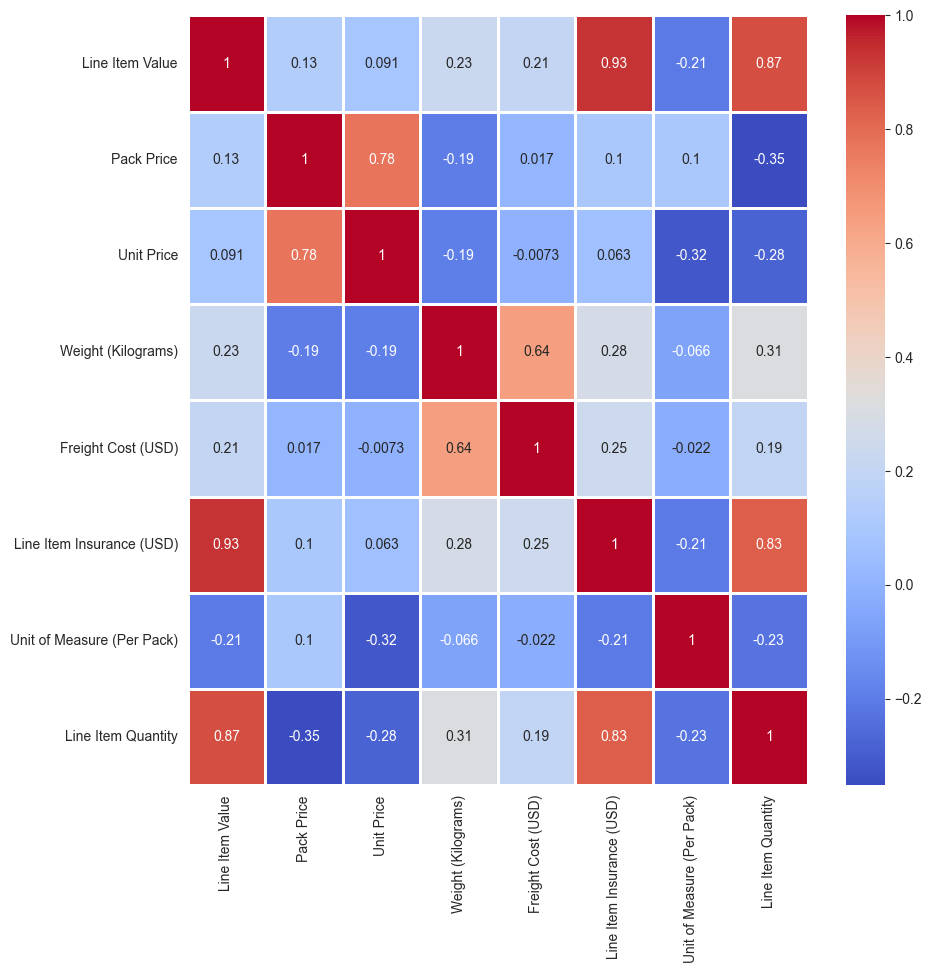

In [58]:
import seaborn as sns
plt.figure(figsize=(10,10))
sns.heatmap(cl_df[num].corr(),cmap='coolwarm',annot=True,linewidth=2)

#Here we can see some more columns to be correlated to each other, which can be dropped, As well as dropping some other irrelevant columns

In [59]:
new_df = cl_df.drop(['Line Item Insurance (USD)' , 'Line Item Value' , 'Scheduled Delivery Date',  'Delivered to Client Date' , 'Manufacturing Site'] , axis =1)
new_df.columns

Index(['Country', 'Fulfill Via', 'Vendor INCO Term', 'Shipment Mode',
       'Product Group', 'Sub Classification', 'Molecule/Test Type', 'Brand',
       'Dosage', 'Dosage Form', 'Unit of Measure (Per Pack)',
       'Line Item Quantity', 'Pack Price', 'Unit Price',
       'First Line Designation', 'Weight (Kilograms)', 'Freight Cost (USD)',
       'Schedule v Actual', 'Shipping_cost'],
      dtype='object')

In [60]:
new_df

,Country,Fulfill Via,Vendor INCO Term,Shipment Mode,Product Group,Sub Classification,Molecule/Test Type,Brand,Dosage,Dosage Form,Unit of Measure (Per Pack),Line Item Quantity,Pack Price,Unit Price,First Line Designation,Weight (Kilograms),Freight Cost (USD),Schedule v Actual,Shipping_cost
1,38,0,5,0,2,5,53,12,2,7,5.49,6.91,2.10,0.71,1,5.89,8.42,0.00,17.89
2,9,0,6,0,3,2,21,8,9,14,4.62,6.22,4.41,1.03,1,5.15,7.41,0.00,18.75
3,38,0,5,0,2,1,40,12,13,9,4.13,10.37,1.79,0.73,1,7.53,9.68,0.00,22.18
4,38,0,5,0,2,1,59,12,34,0,4.13,10.55,1.65,0.72,1,8.93,10.72,0.00,23.17
5,26,0,5,0,2,5,62,12,2,6,5.49,6.04,1.99,0.70,1,6.23,8.69,0.00,17.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10319,40,1,7,3,2,5,42,12,25,2,4.13,12.02,1.72,0.72,0,8.14,9.32,16.00,29.18
10320,9,1,7,3,2,1,45,12,10,10,4.13,9.96,2.14,0.75,0,8.14,9.32,-6.00,26.24
10321,39,1,7,3,2,1,13,12,46,10,3.47,13.15,2.48,0.85,0,8.14,9.32,6.00,33.34
10322,40,1,7,3,2,1,45,12,10,10,4.13,9.77,2.14,0.75,1,7.24,9.32,36.00,25.87


In [61]:
new_df.shape

(8823, 19)

## Dividing the data

In [62]:
X = new_df.iloc[:,:-1]
y = new_df['Shipping_cost']

In [63]:
#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

*** Extre_tree ***


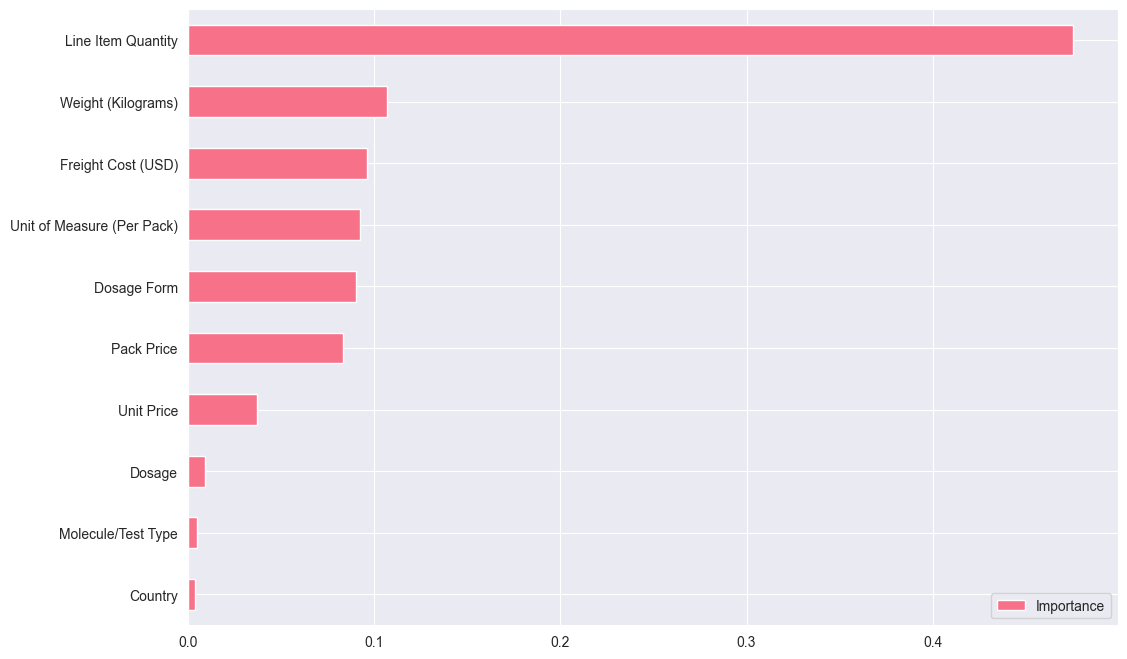



*** Random_forest ***


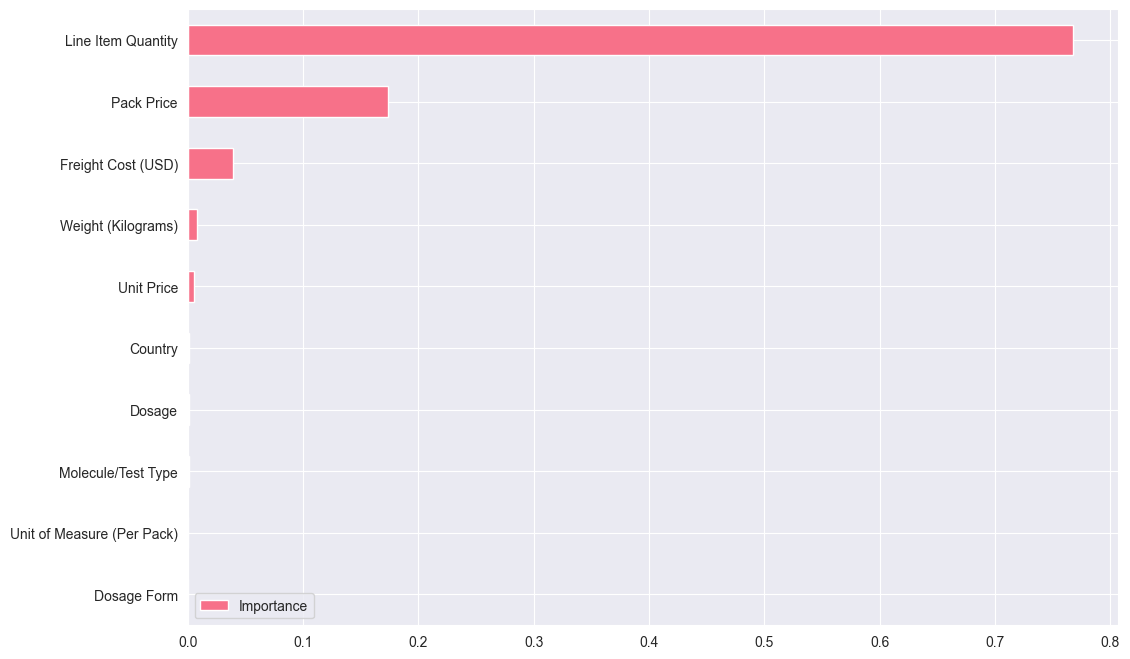



*** Ada_boost ***


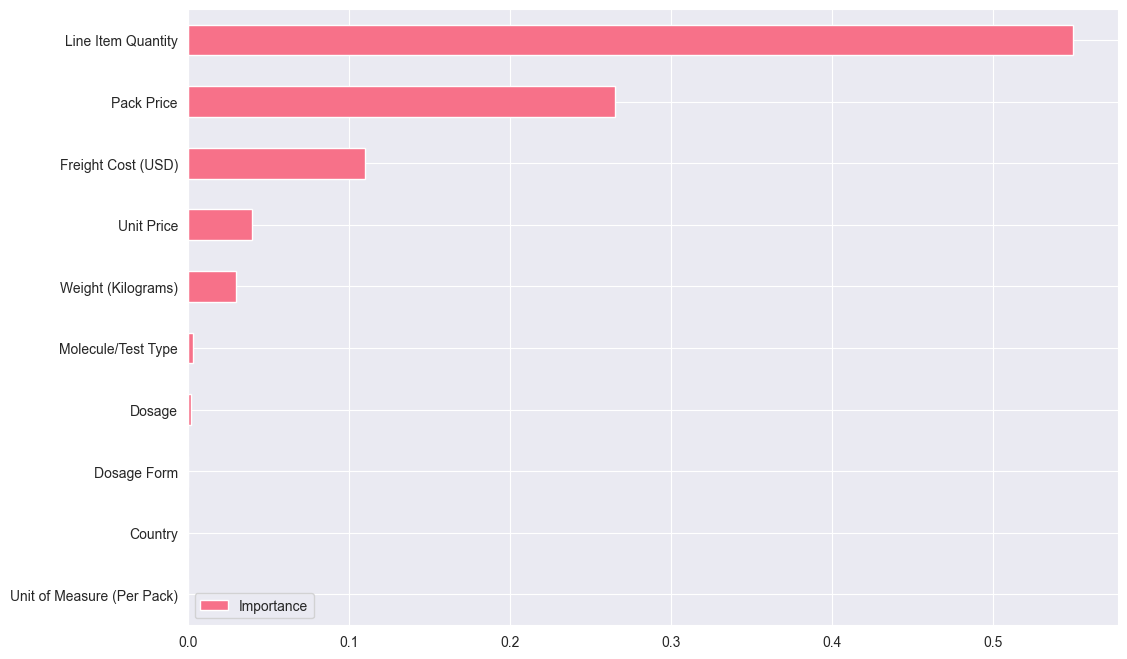



*** XGBoost ***


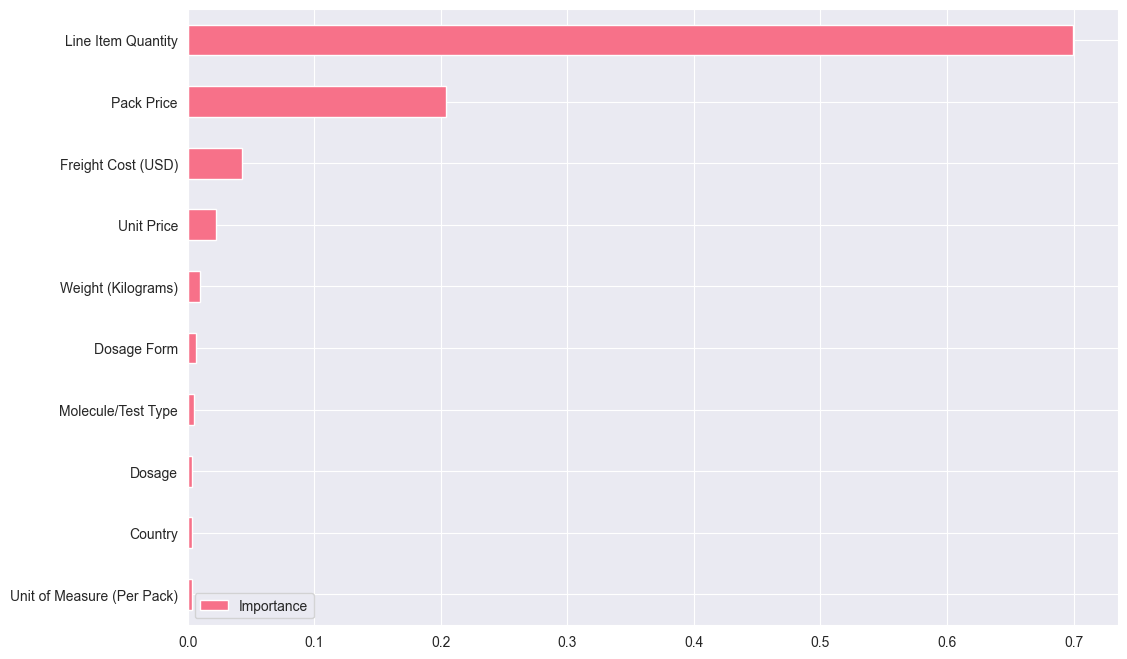



*** Gradient_Boost ***


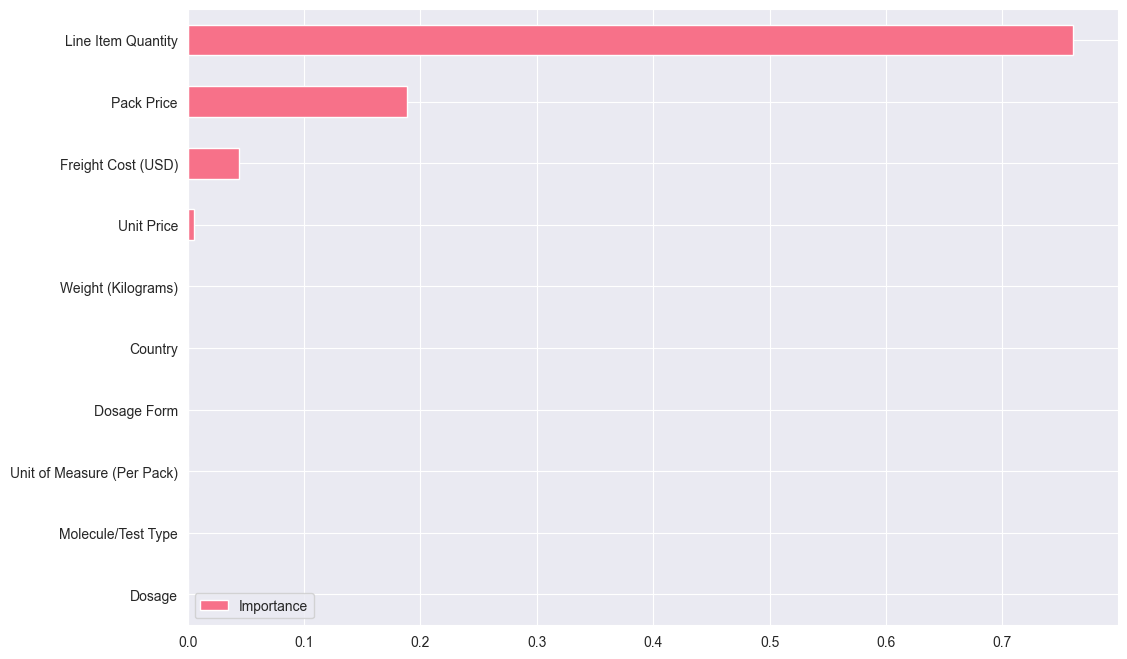



*** Decison_tree ***


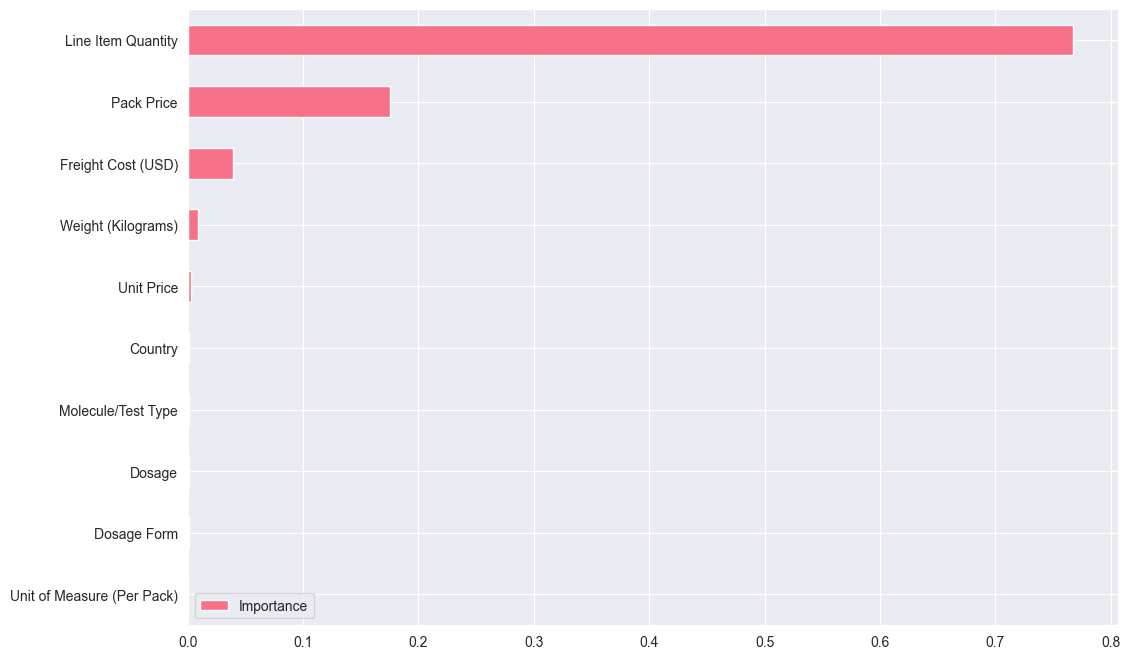

In [64]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression
scores = mutual_info_regression(X_train, y_train)

# Select the top k features based on the scores
k = 10
top_k_features = X.columns[np.argsort(scores)[-k:]]

# Train a Random Forest Regressor on the top k features
X_top_k = X[top_k_features]
models = { 
    'Extre_tree': ExtraTreeRegressor(),
    #'KNN_neighboure': KNeighborsRegressor(), (found out that it does not have attribute feature_importance)
    #'lasso' : Lasso(), (same reason as above)
    #'SVM' : svr(),
    'Random_forest' : RandomForestRegressor(),
    'Ada_boost': AdaBoostRegressor(),
    'XGBoost' : XGBRegressor(),
    'Gradient_Boost': GradientBoostingRegressor(),
    'Decison_tree': DecisionTreeRegressor()
}
for model_name , model in models.items():
  model.fit(X_top_k, y)
  # Plot the importance of each feature
  print ("***", model_name, "***")
  importance = model.feature_importances_
  importance = pd.DataFrame(importance, index=top_k_features, columns=['Importance'])
  importance.sort_values(by='Importance', inplace=True)
  importance.plot(kind='barh', figsize=(12, 8) , color = sns.color_palette("husl"))
  plt.show()
  print('\n')

### From this it is clear that 5 most important features are 'Line Item Quantity', 'Freight cost', 'Weight', 'Pack Price', 'Unit Price'

## Model Training using LazyPredict (An auto-ml library to train lot of models at once)

In [ ]:
#machine learning model pipeline
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None, regressors = [LinearRegression,
                                                                                       Lasso,
                                                                                       Ridge,
                                                                                       ElasticNet,
                                                                                       KNeighborsRegressor,
                                                                                       DecisionTreeRegressor,
                                                                                       RandomForestRegressor,
                                                                                       GradientBoostingRegressor,
                                                                                       AdaBoostRegressor,
                                                                                       SVR,
                                                                                       ExtraTreeRegressor,
                                                                                       XGBRegressor,
                                                                                       ElasticNetCV,
                                                                                       LGBMRegressor,
                                                                                       BaggingRegressor])
# fitting data in LazyClassifier
algo, predictions = reg.fit(X_train, X_test, y_train, y_test)
print(algo)

100%|██████████| 15/15 [00:12<00:00,  1.23it/s]

                           Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                     
LGBMRegressor                            0.98       0.98  0.03        0.15
XGBRegressor                             0.98       0.98  0.03        0.54
RandomForestRegressor                    0.98       0.98  0.03        7.21
GradientBoostingRegressor                0.98       0.98  0.03        1.90
BaggingRegressor                         0.97       0.97  0.03        0.82
Ridge                                    0.97       0.97  0.03        0.02
LinearRegression                         0.97       0.97  0.03        0.03
ElasticNetCV                             0.97       0.97  0.03        0.11
DecisionTreeRegressor                    0.96       0.96  0.04        0.09
ExtraTreeRegressor                       0.95       0.95  0.04        0.06
AdaBoostRegressor                        0.90       0.91  0.06        0.72
SVR                      

## The best performing models are LGBM, RandomForest, XGB.
## Lets Try to tune them and see whether we can increase the performance or not 

This codes will perform a randomized search over the hyperparameter space defined by param_dist, using 5-fold cross-validation and 100 iterations. The best hyperparameters will be stored in the best_params_ attribute

# Random_Forest

In [ ]:
param_dist = {'n_estimators': randint(50, 200),
              'max_depth': randint(1, 20),
              'min_samples_split': randint(2, 10),
              'min_samples_leaf': randint(1, 10),
              'max_features': randint(1, X_train.shape[1])}

# Create the Random Forest Regressor model
rfr = RandomForestRegressor()

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(rfr, param_distributions=param_dist, n_iter=100, cv=5, n_jobs=-1)

# Fit the RandomizedSearchCV object to the data
random_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters: ", random_search.best_params_)

Best hyperparameters:  {'max_depth': 15, 'max_features': 14, 'min_samples_leaf': 1, 'min_samples_split': 9, 'n_estimators': 193}


# LGBM_Regressor

In [ ]:
param_dist = {'n_estimators': randint(50, 200),
              'max_depth': randint(1, 20),
              'num_leaves': randint(5, 50),
              'learning_rate': [0.01, 0.05, 0.1],
              'feature_fraction': [0.6, 0.8, 1.0],
              'bagging_fraction': [0.6, 0.8, 1.0]}

# Create the LightGBM Regressor model
lgbm = LGBMRegressor()

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(lgbm, param_distributions=param_dist, n_iter=100, cv=5, n_jobs=-1)

# Fit the RandomizedSearchCV object to the data
random_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters: ", random_search.best_params_)

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
Best hyperparameters:  {'bagging_fraction': 0.8, 'feature_fraction': 1.0, 'learning_rate': 0.1, 'max_depth': 18, 'n_estimators': 146, 'num_leaves': 41}


# XGBRegressor

In [ ]:
param_dist = {'n_estimators': randint(50, 200),
              'max_depth': randint(1, 20),
              'learning_rate': uniform(0.01, 0.3),
              'min_child_weight': randint(1, 10),
              'subsample': uniform(0.1, 0.9)}

# Create the XGBoost Regressor model
xgbr = XGBRegressor()

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(xgbr, param_distributions=param_dist, n_iter=100, cv=5, n_jobs=-1)

# Fit the RandomizedSearchCV object to the data
random_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters: ", random_search.best_params_)

Best hyperparameters:  {'learning_rate': 0.061151461095385544, 'max_depth': 12, 'min_child_weight': 6, 'n_estimators': 188, 'subsample': 0.5270913029392809}


In [ ]:
model_pipeline = []

model_pipeline.append(RandomForestRegressor(max_depth = 19 , max_features = 14 , min_samples_leaf = 2, min_samples_split = 2, n_estimators = 200))
model_pipeline.append(LGBMRegressor(max_depth = 13 , bagging_fraction = 1.0 , feature_fraction = 1.0 , learning_rate = 0.1 , n_estimators = 140, num_leaves = 49))
model_pipeline.append(XGBRegressor(learning_rate = 0.05 , max_depth = 15 , min_child_weight = 2 , n_estimators = 200 , subsample = 0.35))

In [ ]:
model_list = ['RandomForest' , 'LightGBM', 'XGBoost']
MAE = []
MSE = []
RMSE = []
RSquared = []

for model in model_pipeline:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    MAE.append(mean_absolute_error(y_test, y_pred))
    MSE.append(mean_squared_error(y_test, y_pred))
    RMSE.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    RSquared.append(r2_score(y_test, y_pred))

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0


In [ ]:
result_df = pd.DataFrame({'Model': model_list, 'Mean Absolute Error': MAE, 'Mean Squared Error': MSE, 'Root Mean Squared Error' : RMSE, 'R-Squared' : RSquared})

In [ ]:
result_df.sort_values(by = 'Mean Absolute Error') #Results have been slightly improved

,Model,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error,R-Squared
2,XGBoost,0.27,0.33,0.58,0.98
1,LightGBM,0.30,0.34,0.59,0.98
0,RandomForest,0.33,0.42,0.65,0.98


### We still have pretty good results for the models. In which the best performing model is **XGBoost**

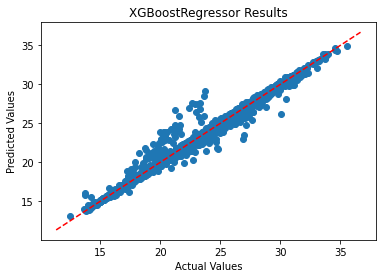

In [ ]:
model = XGBRegressor(learning_rate = 0.05 , max_depth = 15 , min_child_weight = 2 , n_estimators = 200 , subsample = 0.35)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
plt.scatter(y_test, y_pred)

# Plot a line of perfect predictions (predicted = actual)
perfect_preds = np.linspace(*plt.xlim())
plt.plot(perfect_preds, perfect_preds, color='red', linestyle='--')

# Add labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('XGBoostRegressor Results')

# Show the plot
plt.show()

In [ ]:
import pickle
filename = 'xgb_regressor_model.sav'
pickle.dump(model, open(filename, 'wb'))

# Task 2 : Reduce the feature number to 10

In [ ]:
X_top_k

,Unit of Measure (Per Pack),Country,Dosage Form,Unit Price,Pack Price,Molecule/Test Type,Dosage,Freight Cost (USD),Weight (Kilograms),Line Item Quantity
1,2.01,0.95,0.47,1.00,1.41,0.85,0.04,2.34,2.07,2.19
3,1.81,0.95,0.60,1.00,1.33,0.63,0.25,2.46,2.25,2.52
4,1.81,0.95,0.00,1.00,1.29,0.95,0.64,2.54,2.39,2.53
5,2.01,0.65,0.40,0.99,1.38,1.00,0.04,2.37,2.11,2.08
6,1.88,0.98,0.00,1.05,1.71,0.18,0.36,2.43,2.05,1.93
...,...,...,...,...,...,...,...,...,...,...
10319,1.81,1.00,0.13,1.00,1.31,0.67,0.47,2.43,2.32,2.64
10320,1.81,0.23,0.67,1.01,1.42,0.72,0.19,2.43,2.32,2.48
10321,1.70,0.98,0.67,1.05,1.50,0.22,0.89,2.43,2.32,2.72
10322,1.81,1.00,0.67,1.01,1.42,0.72,0.19,2.43,2.22,2.47


In [ ]:
#Train-Test Split
X_train_Top10, X_test_Top10, y_train, y_test = train_test_split(X_top_k, y, test_size=0.3, random_state=42)

In [ ]:
#Using the same previous code, It will work pretty well
model_pipeline = []

model_pipeline.append(RandomForestRegressor(max_depth = 19 , max_features = 5 , min_samples_leaf = 2, min_samples_split = 2, n_estimators = 200))
model_pipeline.append(LGBMRegressor(max_depth = 13 , bagging_fraction = 1.0 , feature_fraction = 1.0 , learning_rate = 0.1 , n_estimators = 140, num_leaves = 49))
model_pipeline.append(XGBRegressor(learning_rate = 0.05 , max_depth = 15 , min_child_weight = 2 , n_estimators = 200 , subsample = 0.35))

model_list = ['RandomForest' , 'LightGBM', 'XGBoost']
MAE = []
MSE = []
RMSE = []
RSquared = []

for model in model_pipeline:
    model.fit(X_train_Top10, y_train)
    y_pred = model.predict(X_test_Top10)
    MAE.append(mean_absolute_error(y_test, y_pred))
    MSE.append(mean_squared_error(y_test, y_pred))
    RMSE.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    RSquared.append(r2_score(y_test, y_pred))

result_df = pd.DataFrame({'Model': model_list, 'Mean Absolute Error': MAE, 'Mean Squared Error': MSE, 'Root Mean Squared Error' : RMSE, 'R-Squared' : RSquared})
result_df.sort_values(by = 'Mean Absolute Error') #Results have got even better

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0


,Model,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error,R-Squared
2,XGBoost,0.05,0.01,0.12,0.94
1,LightGBM,0.05,0.01,0.12,0.94
0,RandomForest,0.06,0.02,0.13,0.94


### Again the best performing model is XGBoost, the results have even improved compared to the first model

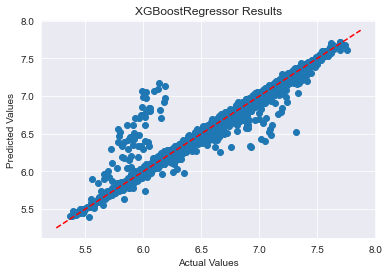

In [ ]:
model = XGBRegressor(learning_rate = 0.05 , max_depth = 15 , min_child_weight = 2 , n_estimators = 200 , subsample = 0.35)
model.fit(X_train_Top10, y_train)
y_pred = model.predict(X_test_Top10)
plt.scatter(y_test, y_pred)

# Plot a line of perfect predictions (predicted = actual)
perfect_preds = np.linspace(*plt.xlim())
plt.plot(perfect_preds, perfect_preds, color='red', linestyle='--')

# Add labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('XGBoostRegressor Results')

# Show the plot
plt.show()

# Task 3 : Reduce the feature number to 5

In [65]:
X_Top_5 = X[['Line Item Quantity', 'Freight Cost (USD)', 'Weight (Kilograms)', 'Pack Price', 'Unit Price']]

In [66]:
X_Top_5

,Line Item Quantity,Freight Cost (USD),Weight (Kilograms),Pack Price,Unit Price
1,6.91,8.42,5.89,2.10,0.71
2,6.22,7.41,5.15,4.41,1.03
3,10.37,9.68,7.53,1.79,0.73
4,10.55,10.72,8.93,1.65,0.72
5,6.04,8.69,6.23,1.99,0.70
...,...,...,...,...,...
10319,12.02,9.32,8.14,1.72,0.72
10320,9.96,9.32,8.14,2.14,0.75
10321,13.15,9.32,8.14,2.48,0.85
10322,9.77,9.32,7.24,2.14,0.75


In [67]:
#Train-Test Split
X_train_Top5, X_test_Top5, y_train, y_test = train_test_split(X_Top_5, y, test_size=0.3, random_state=42)

In [68]:
#Using the same previous code, It will work pretty well
model_pipeline = []

model_pipeline.append(RandomForestRegressor(max_depth = 19 , max_features = 5 , min_samples_leaf = 2, min_samples_split = 2, n_estimators = 200))
model_pipeline.append(LGBMRegressor(max_depth = 13 , bagging_fraction = 1.0 , feature_fraction = 1.0 , learning_rate = 0.1 , n_estimators = 140, num_leaves = 49))
model_pipeline.append(XGBRegressor(learning_rate = 0.05 , max_depth = 15 , min_child_weight = 2 , n_estimators = 200 , subsample = 0.35))

model_list = ['RandomForest' , 'LightGBM', 'XGBoost']
MAE = []
MSE = []
RMSE = []
RSquared = []

for model in model_pipeline:
    model.fit(X_train_Top5, y_train)
    y_pred = model.predict(X_test_Top5)
    MAE.append(mean_absolute_error(y_test, y_pred))
    MSE.append(mean_squared_error(y_test, y_pred))
    RMSE.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    RSquared.append(r2_score(y_test, y_pred))

result_df = pd.DataFrame({'Model': model_list, 'Mean Absolute Error': MAE, 'Mean Squared Error': MSE, 'Root Mean Squared Error' : RMSE, 'R-Squared' : RSquared})
result_df.sort_values(by = 'Mean Absolute Error') #Results have changed

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0


,Model,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error,R-Squared
2,XGBoost,0.29,0.36,0.60,0.98
1,LightGBM,0.33,0.41,0.64,0.98
0,RandomForest,0.34,0.44,0.66,0.98


### Results have slightly detoriated still preety good, 

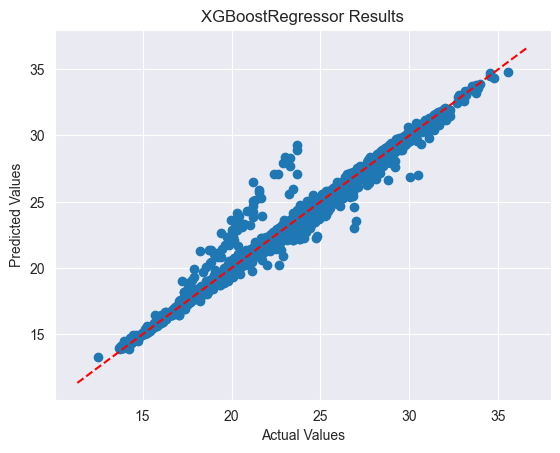

In [69]:
model = XGBRegressor(learning_rate = 0.05 , max_depth = 15 , min_child_weight = 2 , n_estimators = 200 , subsample = 0.35)
model.fit(X_train_Top5, y_train)
y_pred = model.predict(X_test_Top5)
plt.scatter(y_test, y_pred)

# Plot a line of perfect predictions (predicted = actual)
perfect_preds = np.linspace(*plt.xlim())
plt.plot(perfect_preds, perfect_preds, color='red', linestyle='--')

# Add labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('XGBoostRegressor Results')

# Show the plot
plt.show()

In [70]:
model.save_model('xgb_model_5.json')

# Task 4: Train the data with Deep Learning model

In [ ]:
import tensorflow as tf
from tensorflow import keras

model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(10,)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the neural network
history = model.fit(X_train_Top10, y_train, batch_size=32, epochs= 10 , validation_split = 0.25) #epochs updates after training an iteration
test_loss, test_mae = model.evaluate(X_test_Top10, y_test)

Epoch 1/10
132/132 [==============================] - 1s 2ms/step - loss: 6.8802 - mae: 1.6172 - val_loss: 0.1298 - val_mae: 0.2858
Epoch 2/10
132/132 [==============================] - 0s 1ms/step - loss: 0.1182 - mae: 0.2766 - val_loss: 0.1166 - val_mae: 0.2713
Epoch 3/10
132/132 [==============================] - 0s 2ms/step - loss: 0.1053 - mae: 0.2594 - val_loss: 0.1054 - val_mae: 0.2570
Epoch 4/10
132/132 [==============================] - 0s 2ms/step - loss: 0.0939 - mae: 0.2440 - val_loss: 0.0950 - val_mae: 0.2445
Epoch 5/10
132/132 [==============================] - 0s 2ms/step - loss: 0.0837 - mae: 0.2293 - val_loss: 0.0845 - val_mae: 0.2271
Epoch 6/10
132/132 [==============================] - 0s 2ms/step - loss: 0.0726 - mae: 0.2116 - val_loss: 0.0747 - val_mae: 0.2150
Epoch 7/10
132/132 [==============================] - 0s 2ms/step - loss: 0.0641 - mae: 0.1964 - val_loss: 0.0661 - val_mae: 0.1960
Epoch 8/10
132/132 [==============================] - 0s 2ms/step - loss: 0.

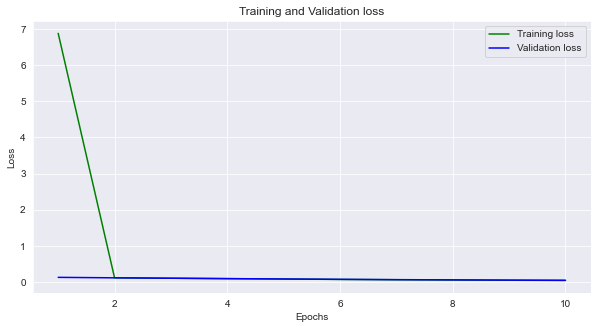

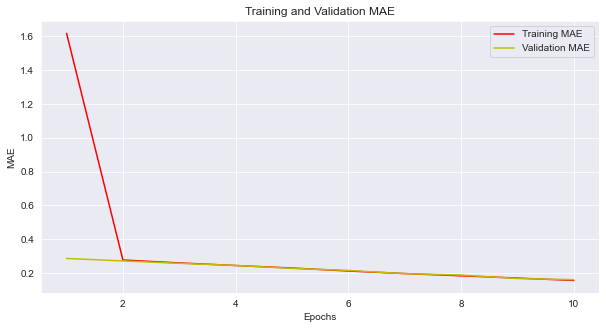

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']

mae_train = history.history['mae']
mae_val = history.history['val_mae']

epochs = range(1,11)
plt.figure(figsize=(10,5))
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure(figsize=(10,5))
plt.plot(epochs, mae_train, 'r', label='Training MAE')
plt.plot(epochs, mae_val, 'y', label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()

Through this visualization, we can see that we are achieving same results similar results since epoch 10 rather than 50 epochs, so let's cut down our resource consumption with only 10 epochs